In [1]:
import scipy.io as sio
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import csv
import sys
import h5py
# 데이터를 담을 빈 리스트 생성
data_frames = []

print("데이터 로드 시작...")

for i in range(1, 11):
    # 1. 파일 경로 수정 (.mat 확장자 추가 및 변수명 오타 수정)
    address = f"ninapro_db5/s{i}/S{i}_E2_A1.mat"
    
    try:
        mat = sio.loadmat(address)
        
        # 2. 데이터 추출
        emg = mat['emg']
        # Ninapro 데이터셋 버전에 따라 키값이 대소문자가 다를 수 있어 안전하게 처리
        Restimulus = mat['restimulus'] if 'restimulus' in mat else mat['Restimulus']
        
        # 3. 데이터프레임 생성
        df_emg = pd.DataFrame(emg)
        df_Restimulus = pd.DataFrame(Restimulus)
        
        # 4. 옆으로 합치기 (axis=1)
        df = pd.concat([df_emg, df_Restimulus], axis=1)
        
        # 5. 컬럼명 지정
        df.columns = [f'emg{k}' for k in range(1, 17)] + ['Restimulus']
        
        # 6. 리스트에 추가 (속도 최적화)
        data_frames.append(df)
        print(f"Subject {i} Loaded.")
        
    except FileNotFoundError:
        print(f"파일을 찾을 수 없습니다: {address}")
    except Exception as e:
        print(f"에러 발생 (Subject {i}): {e}")

# 7. 전체 데이터 하나로 병합 (루프 밖에서 한 번에 수행)
if data_frames:
    ninapro_df5 = pd.concat(data_frames, ignore_index=True)
    print("------------------------------")
    print("모든 데이터 병합 완료")
    print(f"전체 데이터 Shape: {ninapro_df5.shape}")
else:
    print("로드된 데이터가 없습니다.")
    
#ninapro2 데이터셋 불러오기
dfs = []
for i in range(1, 41):
    address = f"ninapro_db2/DB2_s{i}/S{i}_E1_A1.mat"
    try:
        mat = sio.loadmat(address)
        
        emg = mat['emg'] 
        restimulus = mat['restimulus']
        
        n_samples, n_channels = emg.shape
        target_channels = 16
        
        if n_channels < target_channels:
            pad_width = target_channels - n_channels
            zeros = np.zeros((n_samples, pad_width))
            emg_padded = np.hstack([emg, zeros])
        else:
            emg_padded = emg[:, :target_channels]
            

        col_names = [f'emg{k}' for k in range(1, target_channels + 1)]
        df_emg = pd.DataFrame(emg_padded, columns=col_names)
        df_restimulus = pd.DataFrame(restimulus, columns=['Restimulus'])
        
        df_concat = pd.concat([df_emg, df_restimulus], axis=1)
        
        dfs.append(df_concat)
    
    except FileNotFoundError:
        print(f"파일을 찾을 수 없습니다: {address}")
    except Exception as e:
        print(f"Subject {i} 처리 중 에러 발생: {e}")

if dfs:
    ninapro_df2 = pd.concat(dfs, ignore_index=True)
    print("-" * 30)
    print("최종 병합 완료")
    print(f"전체 데이터 Shape: {ninapro_df2.shape}")
    print(f"컬럼 목록: {list(ninapro_df2.columns)}")
else:
    print("데이터가 로드되지 않았습니다.")

#nature df csv불러오는 코드
nature_df = pd.read_csv('nature_df.csv')
print(f"전체 데이터 Shape: {nature_df.shape}")

데이터 로드 시작...
Subject 1 Loaded.
Subject 2 Loaded.
Subject 3 Loaded.
Subject 4 Loaded.
Subject 5 Loaded.
Subject 6 Loaded.
Subject 7 Loaded.
Subject 8 Loaded.
Subject 9 Loaded.
Subject 10 Loaded.
------------------------------
모든 데이터 병합 완료
전체 데이터 Shape: (2023639, 17)
------------------------------
최종 병합 완료
전체 데이터 Shape: (71622258, 17)
컬럼 목록: ['emg1', 'emg2', 'emg3', 'emg4', 'emg5', 'emg6', 'emg7', 'emg8', 'emg9', 'emg10', 'emg11', 'emg12', 'emg13', 'emg14', 'emg15', 'emg16', 'Restimulus']
전체 데이터 Shape: (47973920, 17)


감지된 이벤트 개수: 2개
감지된 인덱스 위치: [23, 2027]


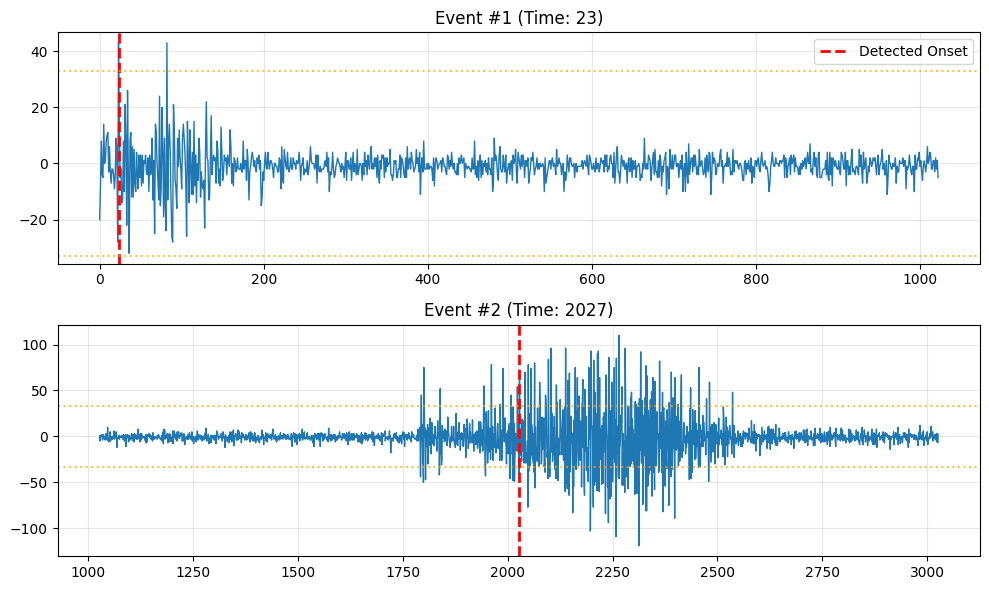

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ---------------------------------------------------------
# 1. 설정 및 준비
# ---------------------------------------------------------
target_col = ninapro_df5.columns[0]  # 첫 번째 센서 컬럼 사용
signal = ninapro_df5[target_col].values # numpy 배열로 변환 (속도 향상)
times = ninapro_df5.index # 시간축

# (1) 임계값(Threshold) 자동 계산
# 처음 0.5초(약 1000개 샘플)를 휴식 구간으로 가정
rest_samples = 1000
threshold = np.mean(signal[:rest_samples]) + (6 * np.std(signal[:rest_samples])) # 표준편차의 6배

# (2) 이벤트 탐지 설정
events = []
min_distance = 2000  # [중요] 최소 간격: 2000샘플(1초). 이 시간 안에는 중복 탐지 안 함.
last_event_idx = -min_distance # 초기값 설정

# ---------------------------------------------------------
# 2. 순차적으로 5개의 이벤트 찾기
# ---------------------------------------------------------
for i in range(len(signal)):
    # 절대값이 임계값을 넘고, 마지막 감지로부터 1초 이상 지났으면 '새로운 동작'으로 인정
    if (np.abs(signal[i]) > threshold) and (i - last_event_idx > min_distance):
        events.append(i)
        last_event_idx = i
        
        if len(events) == 2: # 5개 찾으면 중단
            break

print(f"감지된 이벤트 개수: {len(events)}개")
print(f"감지된 인덱스 위치: {events}")

# ---------------------------------------------------------
# 3. 5개 구간 시각화 (Subplots)
# ---------------------------------------------------------
if len(events) == 0:
    print("임계값을 넘는 신호를 찾지 못했습니다. threshold 배수를 낮춰주세요.")
else:
    # 감지된 개수만큼만 subplot 생성 (최대 5개)
    fig, axes = plt.subplots(len(events), 1, figsize=(10, 3 * len(events)), sharex=False)
    if len(events) == 1: axes = [axes] # 1개일 경우 리스트로 변환

    window = 1000 # 감지 지점 앞뒤로 보여줄 범위 (약 0.25초)

    for i, ax in enumerate(axes):
        idx = events[i]
        t_event = times[idx]
        
        # 슬라이싱 범위 계산 (배열 범위 안 벗어나게)
        start = max(0, idx - window)
        end = min(len(signal), idx + window)
        
        # 데이터 자르기
        segment_t = times[start:end]
        segment_y = signal[start:end]
        
        # 그래프 그리기
        ax.plot(segment_t, segment_y, color='#1f77b4', lw=1)
        
        # 감지된 순간 표시 (빨간 점선)
        ax.axvline(x=t_event, color='red', linestyle='--', lw=2, label='Detected Onset')
        
        # 임계값 표시 (주황 점선)
        ax.axhline(y=threshold, color='orange', linestyle=':', alpha=0.7)
        ax.axhline(y=-threshold, color='orange', linestyle=':', alpha=0.7)
        
        ax.set_title(f'Event #{i+1} (Time: {t_event})')
        ax.grid(True, alpha=0.3)
        if i == 0: ax.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

In [3]:
import pandas as pd
import numpy as np
from scipy import signal

# 1. 그룹 ID 생성
group_id = (ninapro_df5['Restimulus'] != ninapro_df5['Restimulus'].shift()).cumsum()

# 처리된 조각들을 담을 임시 리스트
processed_segments = []

# 업샘플링 설정
target_fs = 1000
original_fs = 200
scale_factor = int(target_fs / original_fs)  # 5배

print(f"=== 구간별 업샘플링 및 1000단위 절삭 시작 ===")

for gid, segment in ninapro_df5.groupby(group_id):
    rest_value = segment['Restimulus'].iloc[0]
    original_len = len(segment)
    
    # 1. 업샘플링 후 전체 길이 계산
    full_upsampled_len = original_len * scale_factor 
    
    # 2. 1000 단위로 자를 길이 계산 (버림)
    cutoff_len = (full_upsampled_len // 1000) * 1000
    
    # 길이가 1000 미만이면 스킵
    if cutoff_len == 0:
        print(f"Group {gid}: [SKIP] Label={rest_value}, Upsampled Len={full_upsampled_len} (Too Short)")
        continue

    # 3. 리샘플링 (전체 길이로 먼저 늘림)
    resampled_data = signal.resample(segment, full_upsampled_len)
    
    # 4. DataFrame 변환
    new_segment = pd.DataFrame(resampled_data, columns=segment.columns)
    
    # 5. 1000 단위까지만 슬라이싱 (뒷부분 버림)
    new_segment = new_segment.iloc[:cutoff_len]
    
    # 라벨 보정 (리샘플링으로 인해 소수점이 된 값을 정수 라벨로 복구)
    new_segment['Restimulus'] = int(rest_value)

    # ---------------------------------------------------------
    # [요청하신 기능] 로그 출력 (Len: 업샘플링된 길이 -> 저장된 길이)
    # ---------------------------------------------------------
    counts_info = new_segment['Restimulus'].value_counts().to_dict()
    
    print(f"Group {gid}: Label={rest_value}, Len={full_upsampled_len} -> {len(new_segment)} (Saved) | Counts: {counts_info}")

    # 리스트에 추가
    processed_segments.append(new_segment)

# -------------------------------------------------------------
# 리스트를 합쳐서 'ninapro_df5'에 덮어쓰기
# -------------------------------------------------------------
if len(processed_segments) > 0:
    ninapro_df5 = pd.concat(processed_segments).reset_index(drop=True)
    print("\n=== 최종 병합 완료 ===")
    print(f"결과가 'ninapro_df5'에 저장되었습니다.")
    print(f"최종 데이터 크기: {ninapro_df5.shape}")
else:
    print("\n[주의] 저장된 구간이 없습니다 (모두 1000개 미만).")

=== 구간별 업샘플링 및 1000단위 절삭 시작 ===
Group 1: Label=0, Len=8900 -> 8000 (Saved) | Counts: {0: 8000}
Group 2: Label=1, Len=4640 -> 4000 (Saved) | Counts: {1: 4000}
Group 3: Label=0, Len=5375 -> 5000 (Saved) | Counts: {0: 5000}
Group 4: Label=1, Len=3260 -> 3000 (Saved) | Counts: {1: 3000}
Group 5: Label=0, Len=5225 -> 5000 (Saved) | Counts: {0: 5000}
Group 6: Label=1, Len=4365 -> 4000 (Saved) | Counts: {1: 4000}
Group 7: Label=0, Len=4445 -> 4000 (Saved) | Counts: {0: 4000}
Group 8: Label=1, Len=4890 -> 4000 (Saved) | Counts: {1: 4000}
Group 9: Label=0, Len=4280 -> 4000 (Saved) | Counts: {0: 4000}
Group 10: Label=1, Len=4755 -> 4000 (Saved) | Counts: {1: 4000}
Group 11: Label=0, Len=4475 -> 4000 (Saved) | Counts: {0: 4000}
Group 12: Label=1, Len=4815 -> 4000 (Saved) | Counts: {1: 4000}
Group 13: Label=0, Len=4250 -> 4000 (Saved) | Counts: {0: 4000}
Group 14: Label=2, Len=3550 -> 3000 (Saved) | Counts: {2: 3000}
Group 15: Label=0, Len=5725 -> 5000 (Saved) | Counts: {0: 5000}
Group 16: Label=2

In [4]:
import pandas as pd

# 1. 그룹 ID 생성
group_id = (ninapro_df2['Restimulus'] != ninapro_df2['Restimulus'].shift()).cumsum()

df2 = []  # 잘린 df들을 저장할 리스트

print("=== [2000Hz -> 1000Hz 다운샘플링] 및 [1000단위 절삭] 시작 ===")

# 2. 그룹별 순회
for gid, segment in ninapro_df2.groupby(group_id):
    rest_value = segment['Restimulus'].iloc[0]
    
    # ---------------------------------------------------------
    # [추가된 기능] 2000Hz -> 1000Hz 다운샘플링
    # ---------------------------------------------------------
    # 2개 중 1개만 가져옵니다 (데이터를 절반으로 줄임)
    segment = segment.iloc[::2]

    # 다운샘플링 후의 길이 계산
    current_len = len(segment)

    # ---------------------------------------------------------
    # 1000 단위로 길이 계산 (나머지 버림)
    # ---------------------------------------------------------
    cutoff_len = (current_len // 1000) * 1000

    # 1000개 미만이면 저장하지 않고 건너뜀
    if cutoff_len == 0:
        print(f"Group {gid}: [SKIP] Label={rest_value}, Length={current_len} (Too Short)")
        continue
    
    # 계산된 길이만큼만 자르기
    truncated_segment = segment.iloc[:cutoff_len].reset_index(drop=True)
    
    # ---------------------------------------------------------
    # [요청하신 기능] value_counts() 계산
    # ---------------------------------------------------------
    # 결과가 Series 형태이므로 보기 좋게 to_dict()로 변환하여 출력
    counts_info = truncated_segment['Restimulus'].value_counts().to_dict()

    print(f"Group {gid}: Label={rest_value}, Len={current_len} -> {len(truncated_segment)} (Saved) | Counts: {counts_info}")
    
    # 리스트에 추가
    df2.append(truncated_segment)

# 3. 최종 결과를 'ninapro_df2'에 덮어쓰기
if len(df2) > 0:
    ninapro_df2 = pd.concat(df2).reset_index(drop=True)
    print("\n=== 처리 완료 ===")
    print(f"최종 'ninapro_df2' 데이터 크기: {ninapro_df2.shape}")
else:
    print("\n[주의] 저장된 구간이 없습니다 (모두 1000개 미만).")

=== [2000Hz -> 1000Hz 다운샘플링] 및 [1000단위 절삭] 시작 ===
Group 1: Label=0, Len=5413 -> 5000 (Saved) | Counts: {0: 5000}
Group 2: Label=1, Len=7111 -> 7000 (Saved) | Counts: {1: 7000}
Group 3: Label=0, Len=2410 -> 2000 (Saved) | Counts: {0: 2000}
Group 4: Label=1, Len=6462 -> 6000 (Saved) | Counts: {1: 6000}
Group 5: Label=0, Len=2327 -> 2000 (Saved) | Counts: {0: 2000}
Group 6: Label=1, Len=6426 -> 6000 (Saved) | Counts: {1: 6000}
Group 7: Label=0, Len=2325 -> 2000 (Saved) | Counts: {0: 2000}
Group 8: Label=1, Len=6483 -> 6000 (Saved) | Counts: {1: 6000}
Group 9: Label=0, Len=2268 -> 2000 (Saved) | Counts: {0: 2000}
Group 10: Label=1, Len=6455 -> 6000 (Saved) | Counts: {1: 6000}
Group 11: Label=0, Len=2296 -> 2000 (Saved) | Counts: {0: 2000}
Group 12: Label=1, Len=6415 -> 6000 (Saved) | Counts: {1: 6000}
Group 13: Label=0, Len=2374 -> 2000 (Saved) | Counts: {0: 2000}
Group 14: Label=2, Len=6502 -> 6000 (Saved) | Counts: {2: 6000}
Group 15: Label=0, Len=2992 -> 2000 (Saved) | Counts: {0: 2000}

In [5]:
import pandas as pd

# 1. 그룹 ID 생성
group_id = (nature_df['Restimulus'] != nature_df['Restimulus'].shift()).cumsum()

df2 = []  # 잘린 df들을 저장할 리스트

print("=== [2000Hz -> 1000Hz 다운샘플링] 및 [1000단위 절삭] 시작 ===")

# 2. 그룹별 순회
for gid, segment in nature_df.groupby(group_id):
    rest_value = segment['Restimulus'].iloc[0]
    
    # ---------------------------------------------------------
    # [추가된 기능] 2000Hz -> 1000Hz 다운샘플링
    # ---------------------------------------------------------
    # 2개 중 1개만 가져옵니다 (데이터를 절반으로 줄임)
    segment = segment.iloc[::2]

    # 다운샘플링 후의 길이 계산
    current_len = len(segment)

    # ---------------------------------------------------------
    # 1000 단위로 길이 계산 (나머지 버림)
    # ---------------------------------------------------------
    cutoff_len = (current_len // 1000) * 1000

    # 1000개 미만이면 저장하지 않고 건너뜀
    if cutoff_len == 0:
        print(f"Group {gid}: [SKIP] Label={rest_value}, Length={current_len} (Too Short)")
        continue
    
    # 계산된 길이만큼만 자르기
    truncated_segment = segment.iloc[:cutoff_len].reset_index(drop=True)
    
    # ---------------------------------------------------------
    # [요청하신 기능] value_counts() 계산
    # ---------------------------------------------------------
    # 결과가 Series 형태이므로 보기 좋게 to_dict()로 변환하여 출력
    counts_info = truncated_segment['Restimulus'].value_counts().to_dict()

    print(f"Group {gid}: Label={rest_value}, Len={current_len} -> {len(truncated_segment)} (Saved) | Counts: {counts_info}")
    
    # 리스트에 추가
    df2.append(truncated_segment)

# 3. 최종 결과를 'nature_df'에 덮어쓰기
if len(df2) > 0:
    nature_df = pd.concat(df2).reset_index(drop=True)
    print("\n=== 처리 완료 ===")
    print(f"최종 'nature_df' 데이터 크기: {nature_df.shape}")
else:
    print("\n[주의] 저장된 구간이 없습니다 (모두 1000개 미만).")

=== [2000Hz -> 1000Hz 다운샘플링] 및 [1000단위 절삭] 시작 ===
Group 1: Label=7, Len=24990 -> 24000 (Saved) | Counts: {7: 24000}
Group 2: Label=6, Len=25000 -> 25000 (Saved) | Counts: {6: 25000}
Group 3: Label=5, Len=24970 -> 24000 (Saved) | Counts: {5: 24000}
Group 4: Label=19, Len=24990 -> 24000 (Saved) | Counts: {19: 24000}
Group 5: Label=18, Len=25000 -> 25000 (Saved) | Counts: {18: 25000}
Group 6: Label=19, Len=24970 -> 24000 (Saved) | Counts: {19: 24000}
Group 7: Label=5, Len=24960 -> 24000 (Saved) | Counts: {5: 24000}
Group 8: Label=18, Len=24960 -> 24000 (Saved) | Counts: {18: 24000}
Group 9: Label=7, Len=25010 -> 25000 (Saved) | Counts: {7: 25000}
Group 10: Label=6, Len=25000 -> 25000 (Saved) | Counts: {6: 25000}
Group 11: Label=5, Len=25030 -> 25000 (Saved) | Counts: {5: 25000}
Group 12: Label=19, Len=24990 -> 24000 (Saved) | Counts: {19: 24000}
Group 13: Label=6, Len=25010 -> 25000 (Saved) | Counts: {6: 25000}
Group 14: Label=18, Len=24990 -> 24000 (Saved) | Counts: {18: 24000}
Group 15:

총 20개의 클래스를 발견했습니다: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
------------------------------------------------------------
Label 0 정보:
  - DB2   : 15294000 samples (4021 Groups)
  - DB5   : 5886000 samples (1021 Groups)
  - Nature: 3974000 samples (32 Groups)
  >>> 그래프 생성 중...


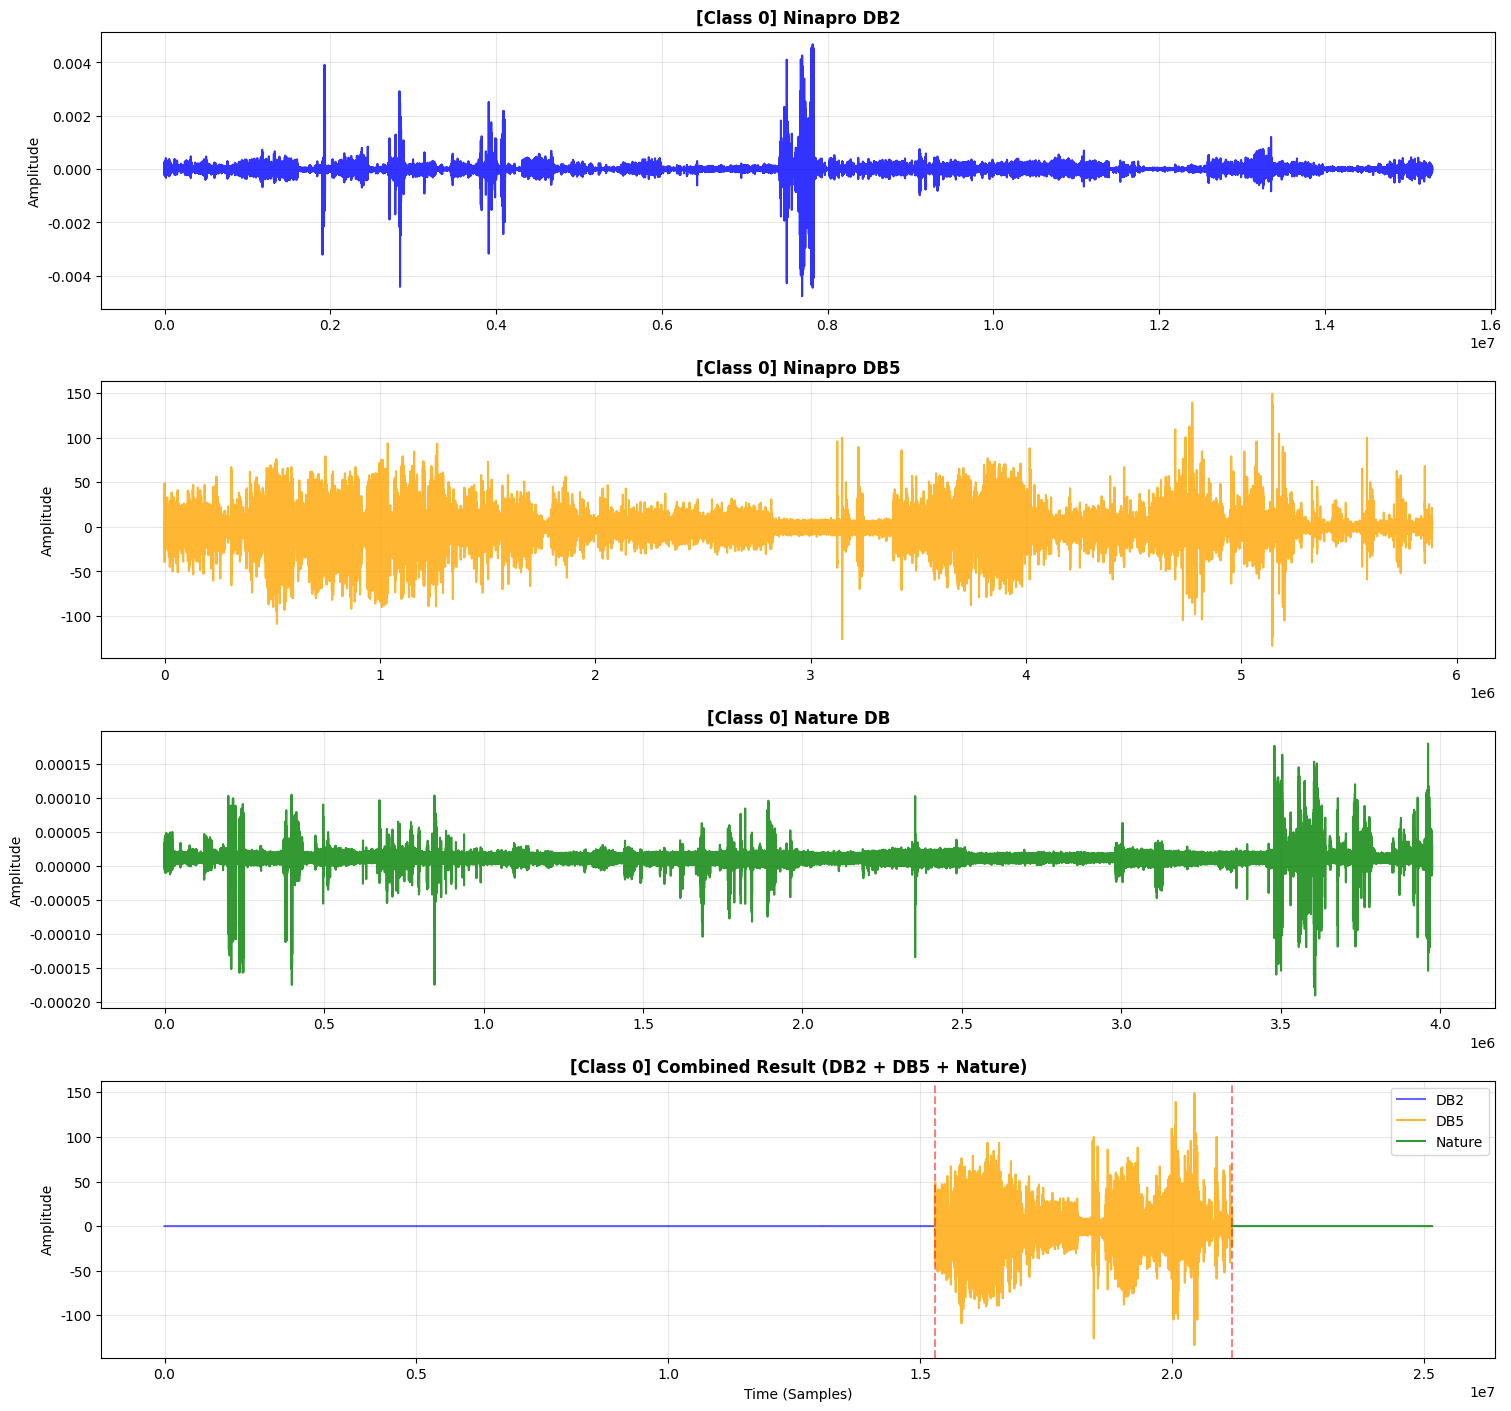

------------------------------------------------------------
Label 1 정보:
  - DB2   : 1352000 samples (240 Groups)
  - DB5   : 220000 samples (60 Groups)
  - Nature: 0 samples (0 Groups)
  >>> 그래프 생성 중...


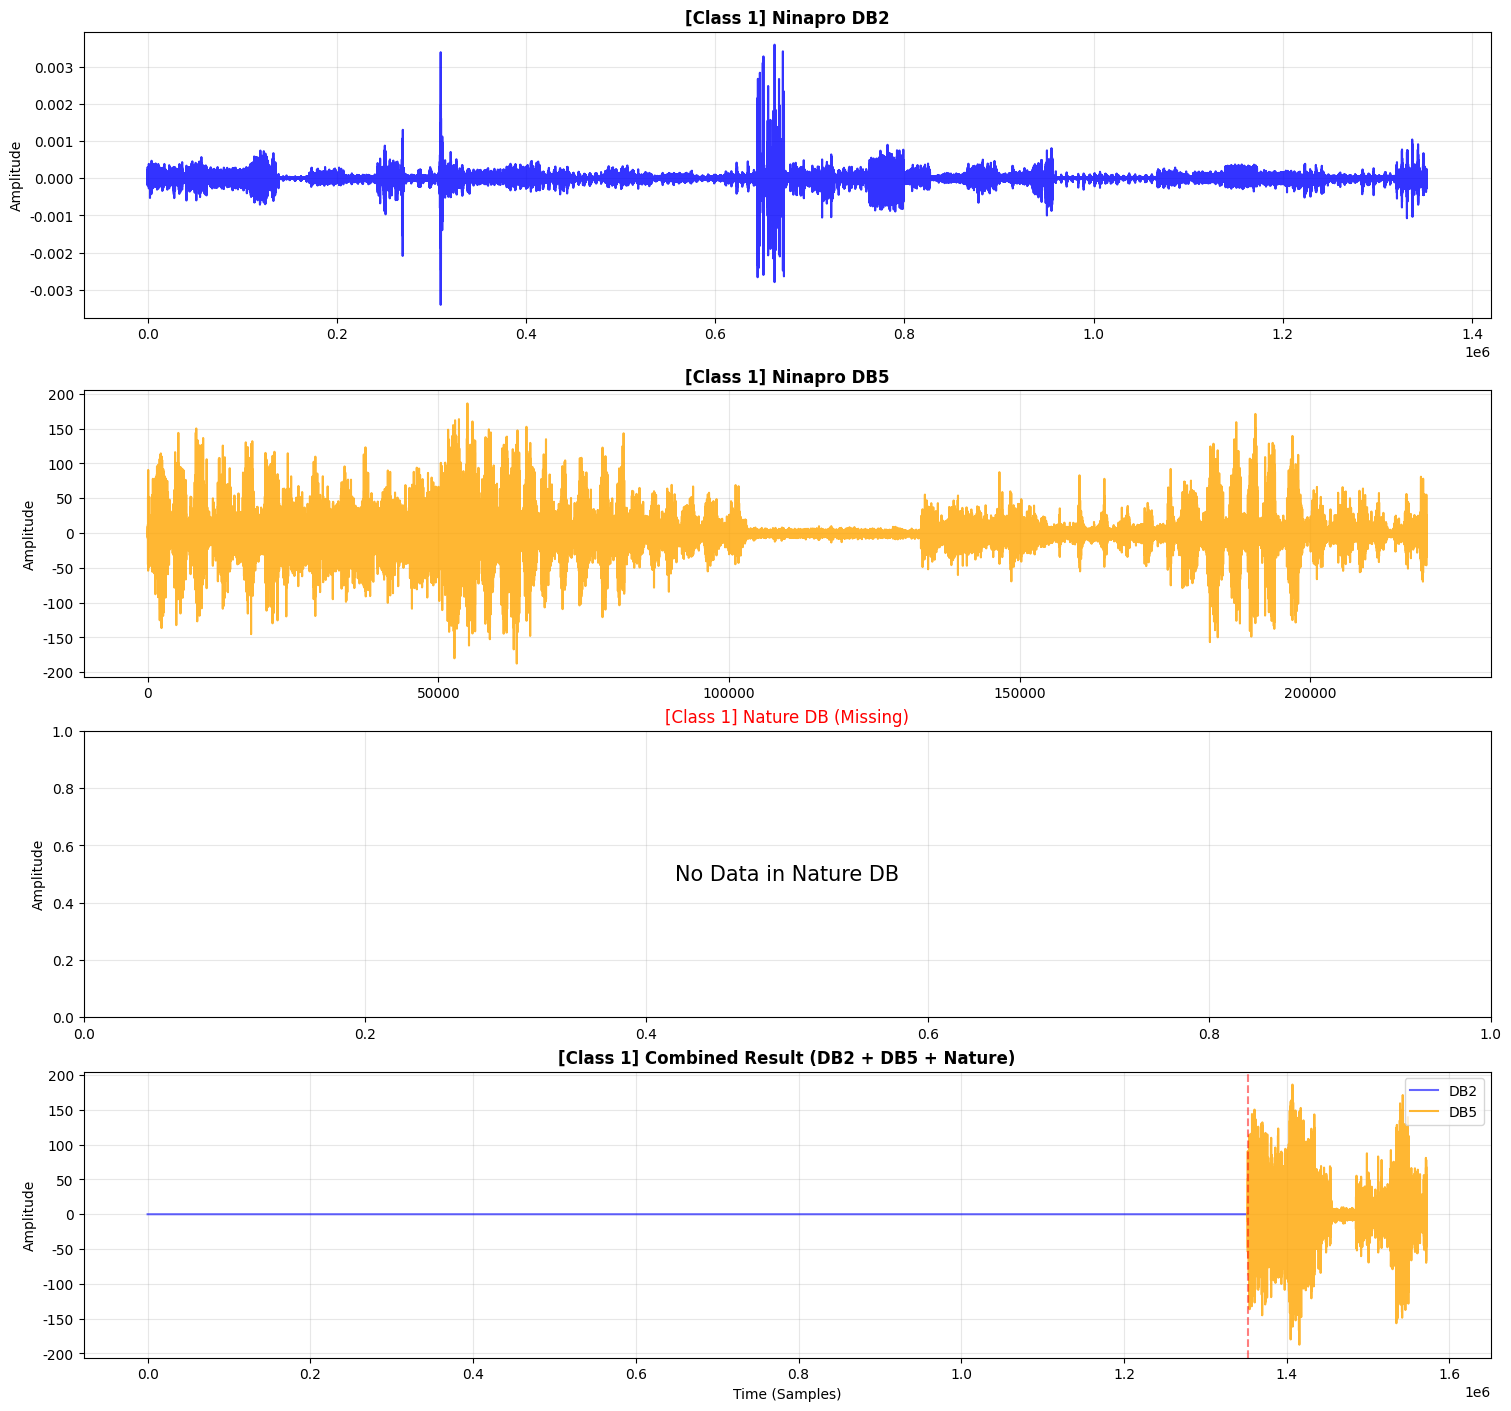

------------------------------------------------------------
Label 2 정보:
  - DB2   : 1168000 samples (238 Groups)
  - DB5   : 184000 samples (60 Groups)
  - Nature: 0 samples (0 Groups)
  >>> 그래프 생성 중...


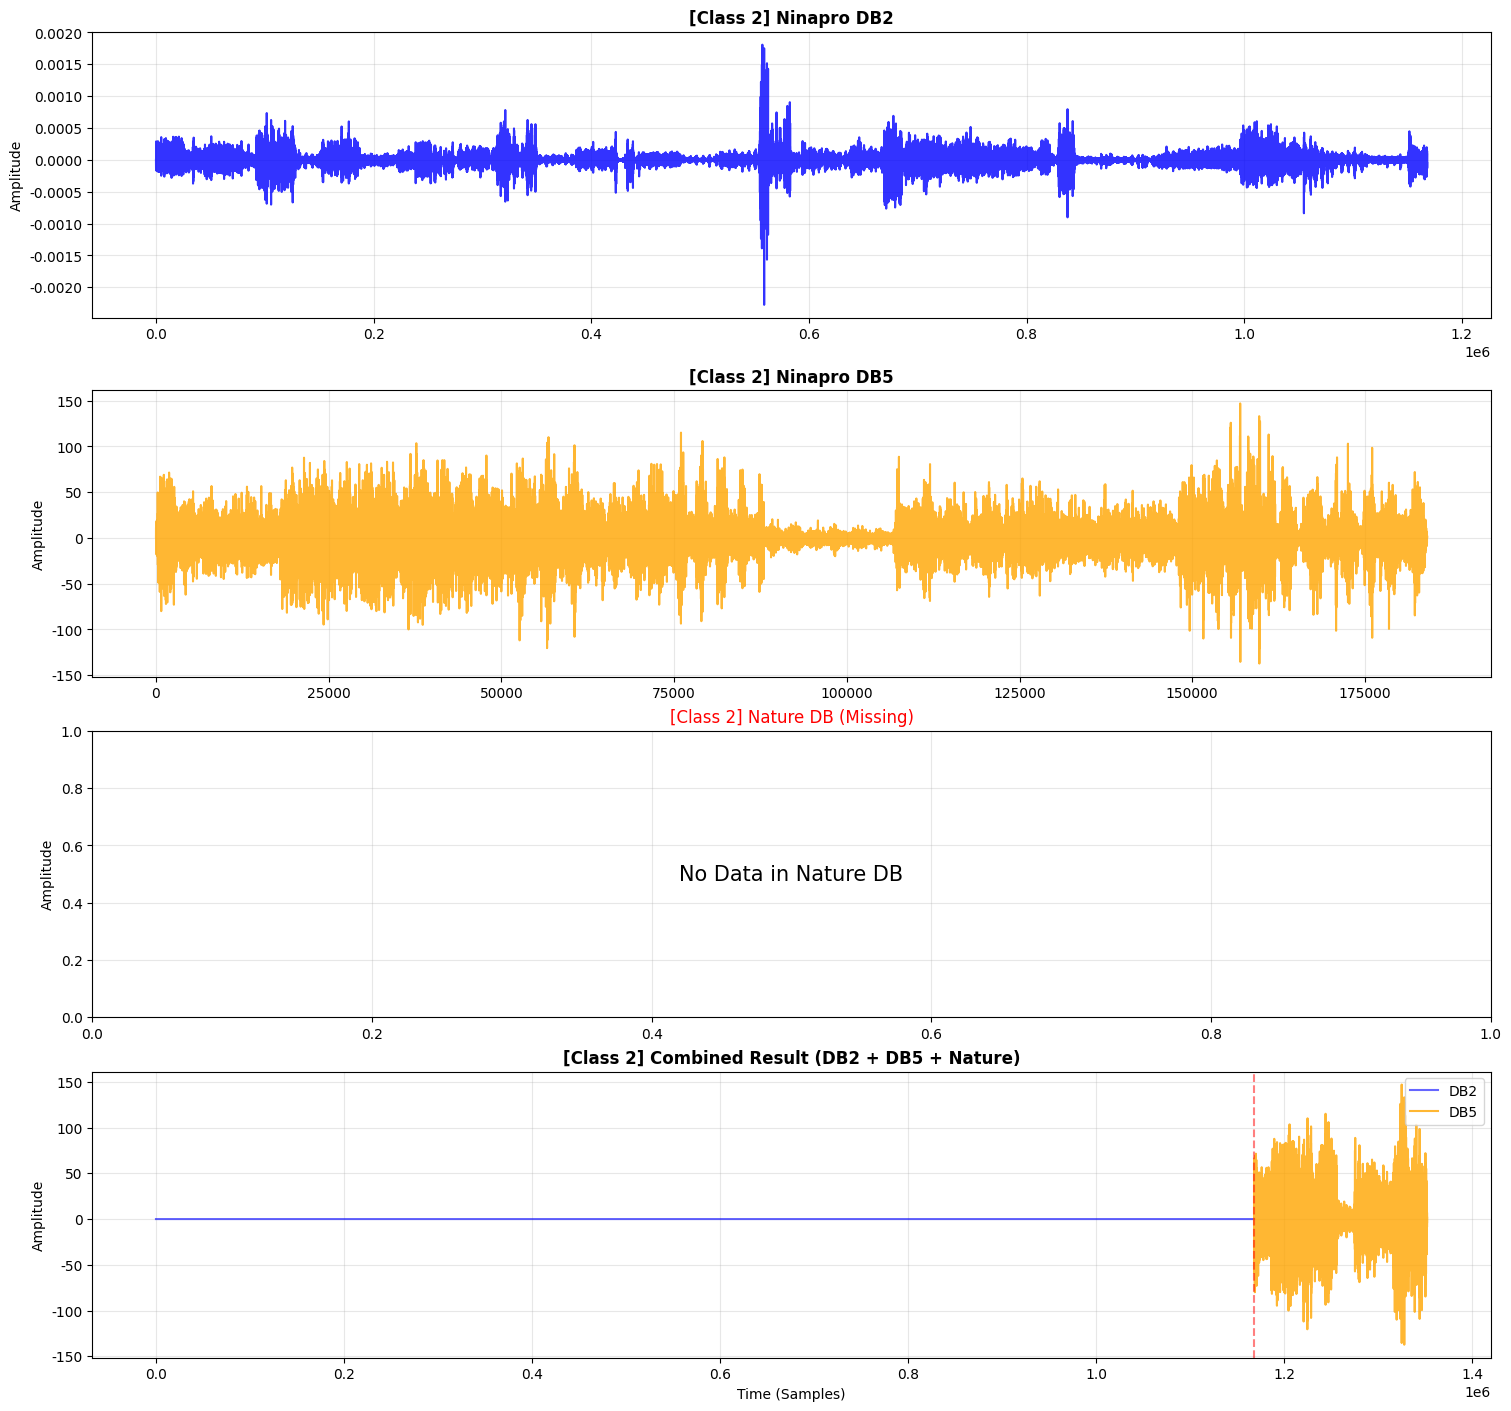

------------------------------------------------------------
Label 3 정보:
  - DB2   : 1008000 samples (239 Groups)
  - DB5   : 184000 samples (60 Groups)
  - Nature: 0 samples (0 Groups)
  >>> 그래프 생성 중...


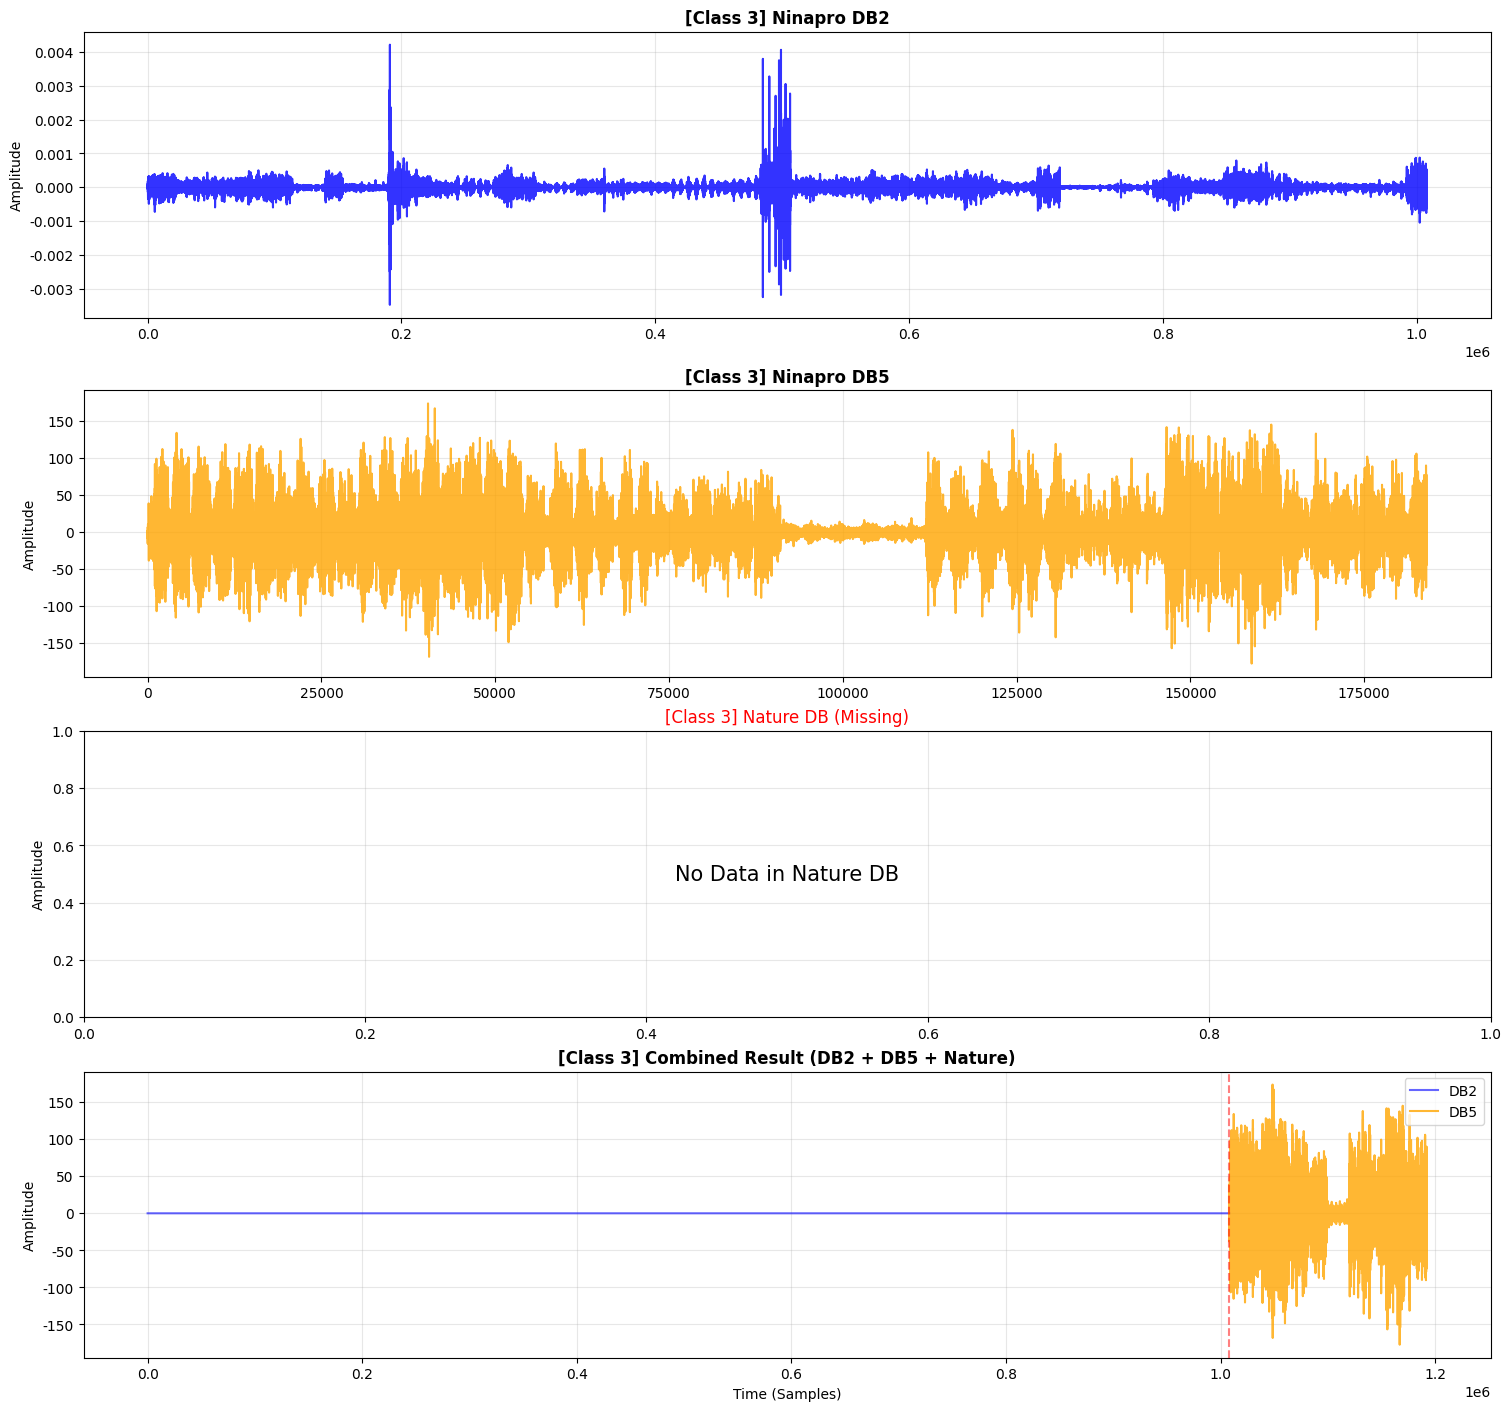

------------------------------------------------------------
Label 4 정보:
  - DB2   : 982000 samples (239 Groups)
  - DB5   : 186000 samples (60 Groups)
  - Nature: 0 samples (0 Groups)
  >>> 그래프 생성 중...


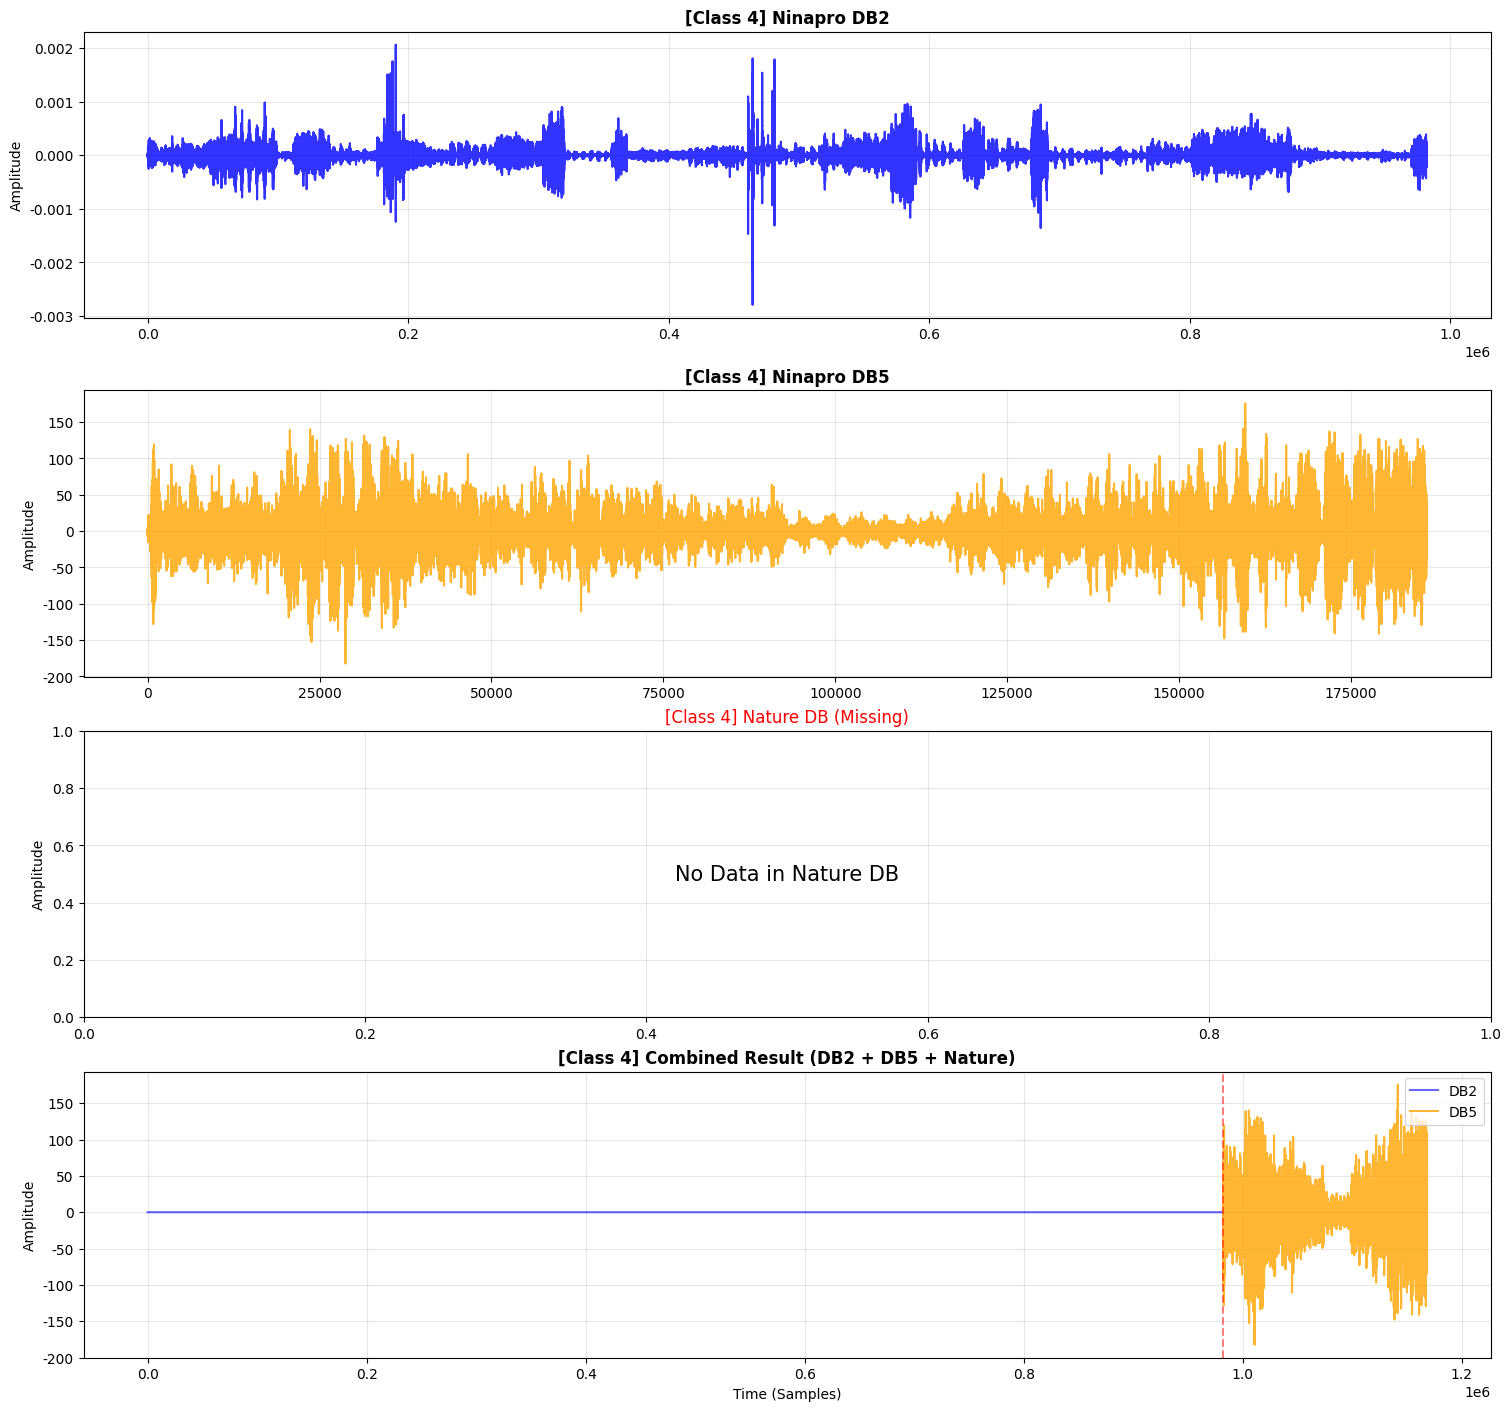

------------------------------------------------------------
Label 5 정보:
  - DB2   : 972000 samples (236 Groups)
  - DB5   : 160000 samples (60 Groups)
  - Nature: 3898000 samples (157 Groups)
  >>> 그래프 생성 중...


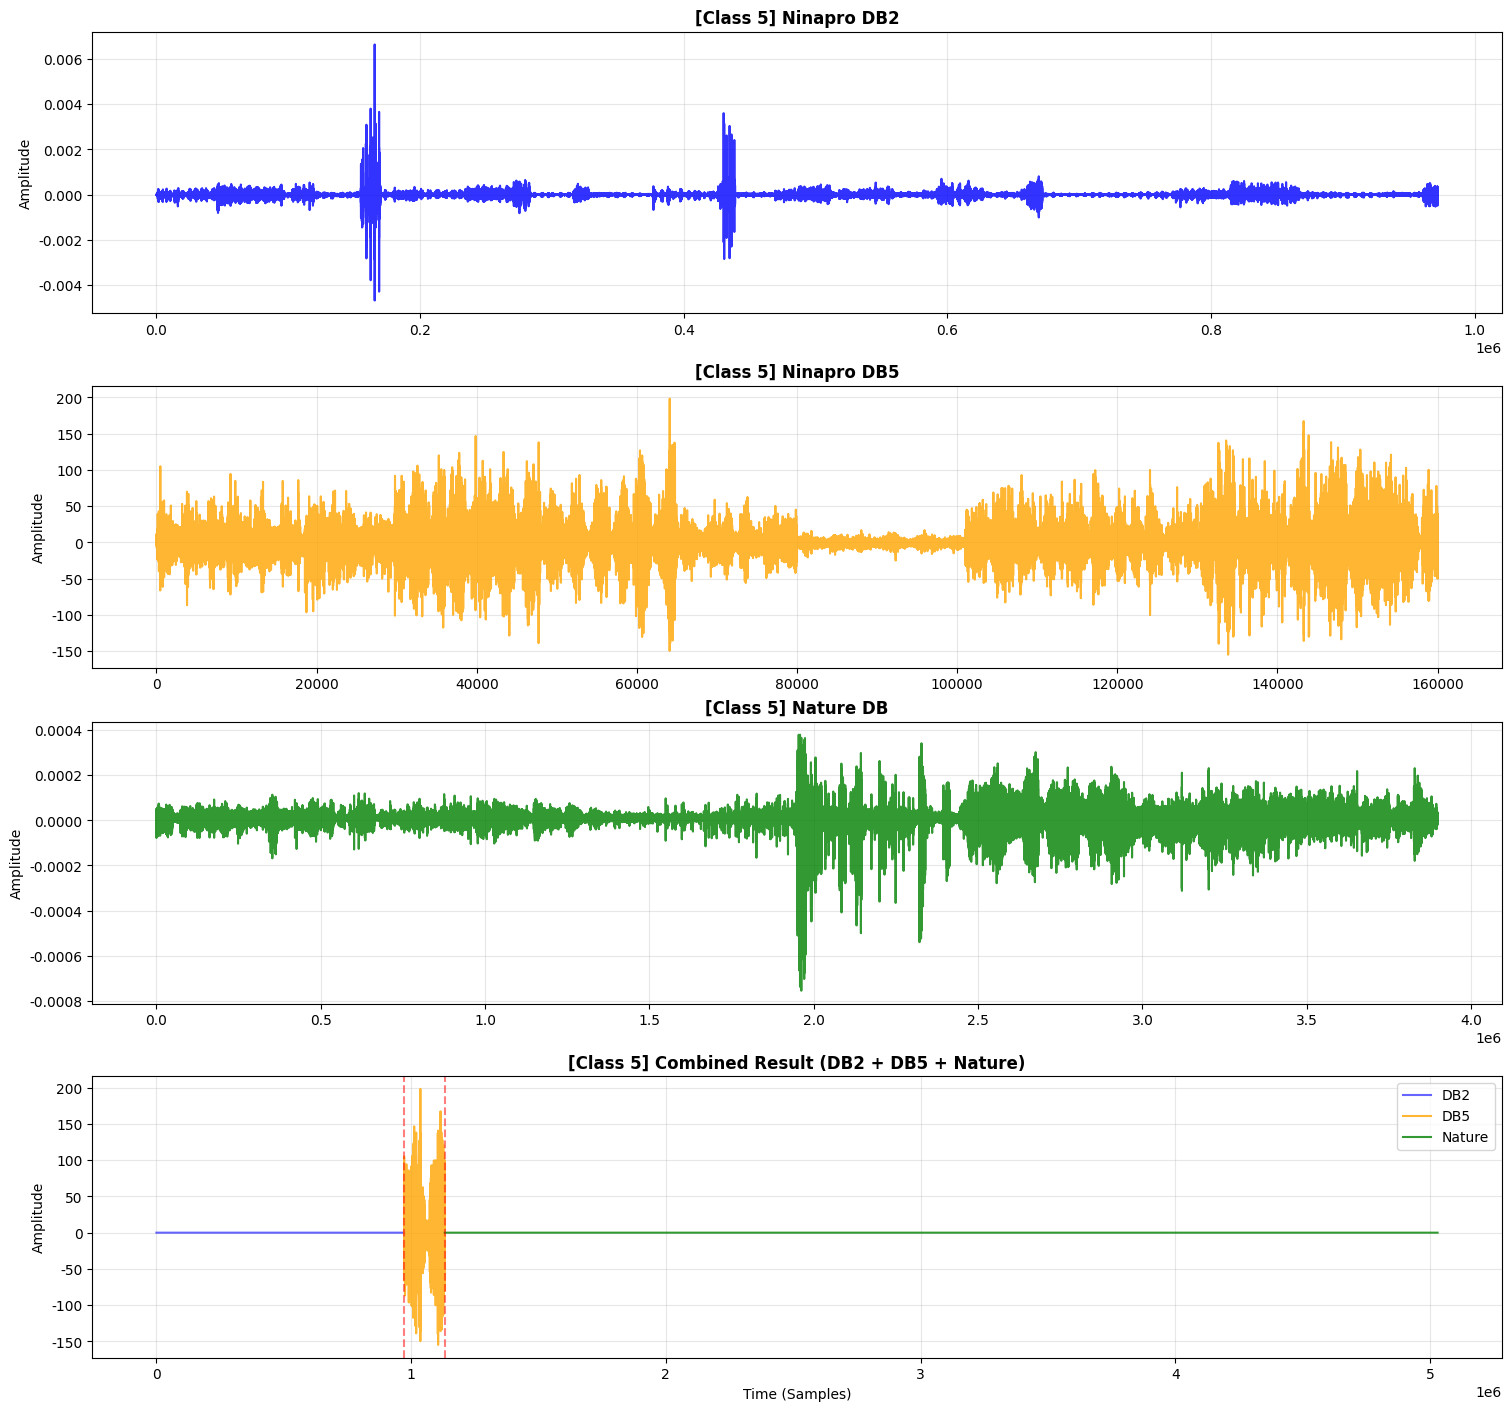

------------------------------------------------------------
Label 6 정보:
  - DB2   : 832000 samples (233 Groups)
  - DB5   : 166000 samples (60 Groups)
  - Nature: 3898000 samples (159 Groups)
  >>> 그래프 생성 중...


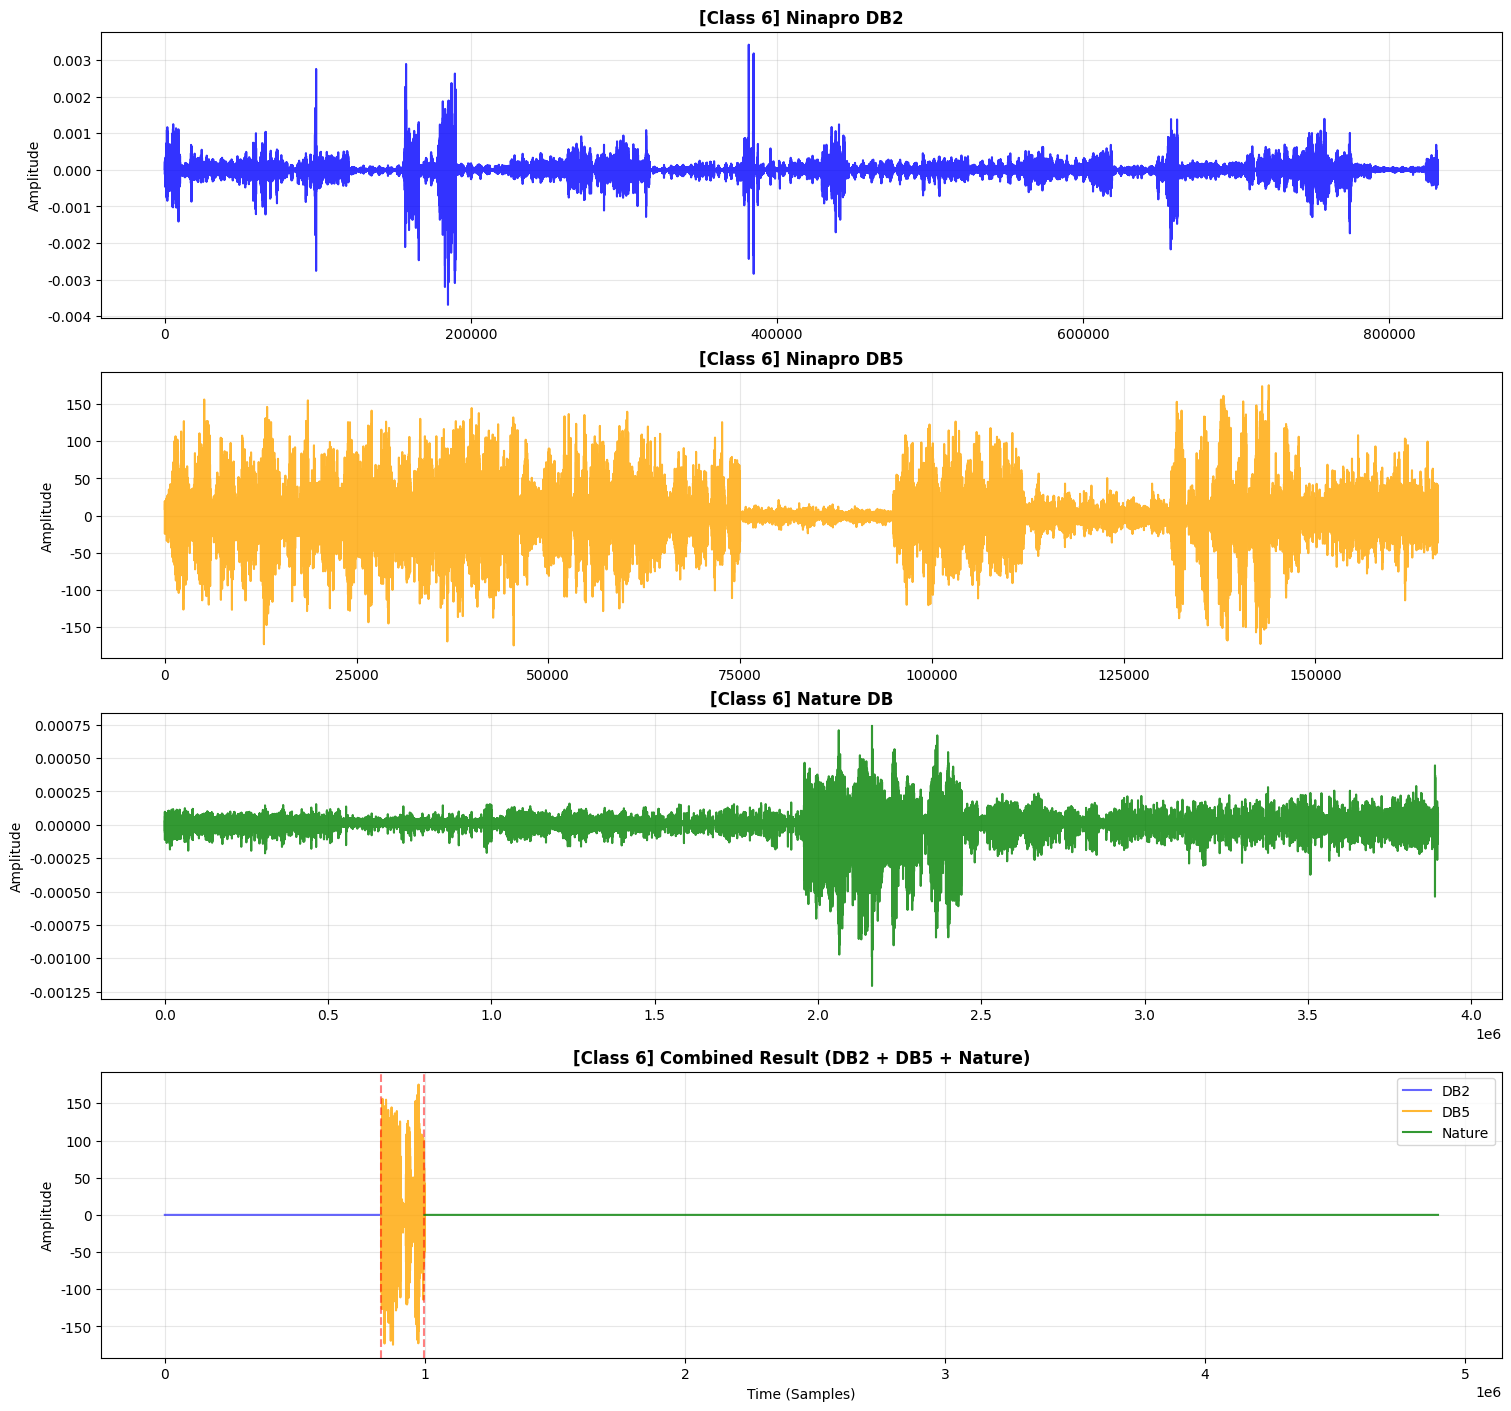

------------------------------------------------------------
Label 7 정보:
  - DB2   : 1268000 samples (240 Groups)
  - DB5   : 192000 samples (60 Groups)
  - Nature: 3900000 samples (160 Groups)
  >>> 그래프 생성 중...


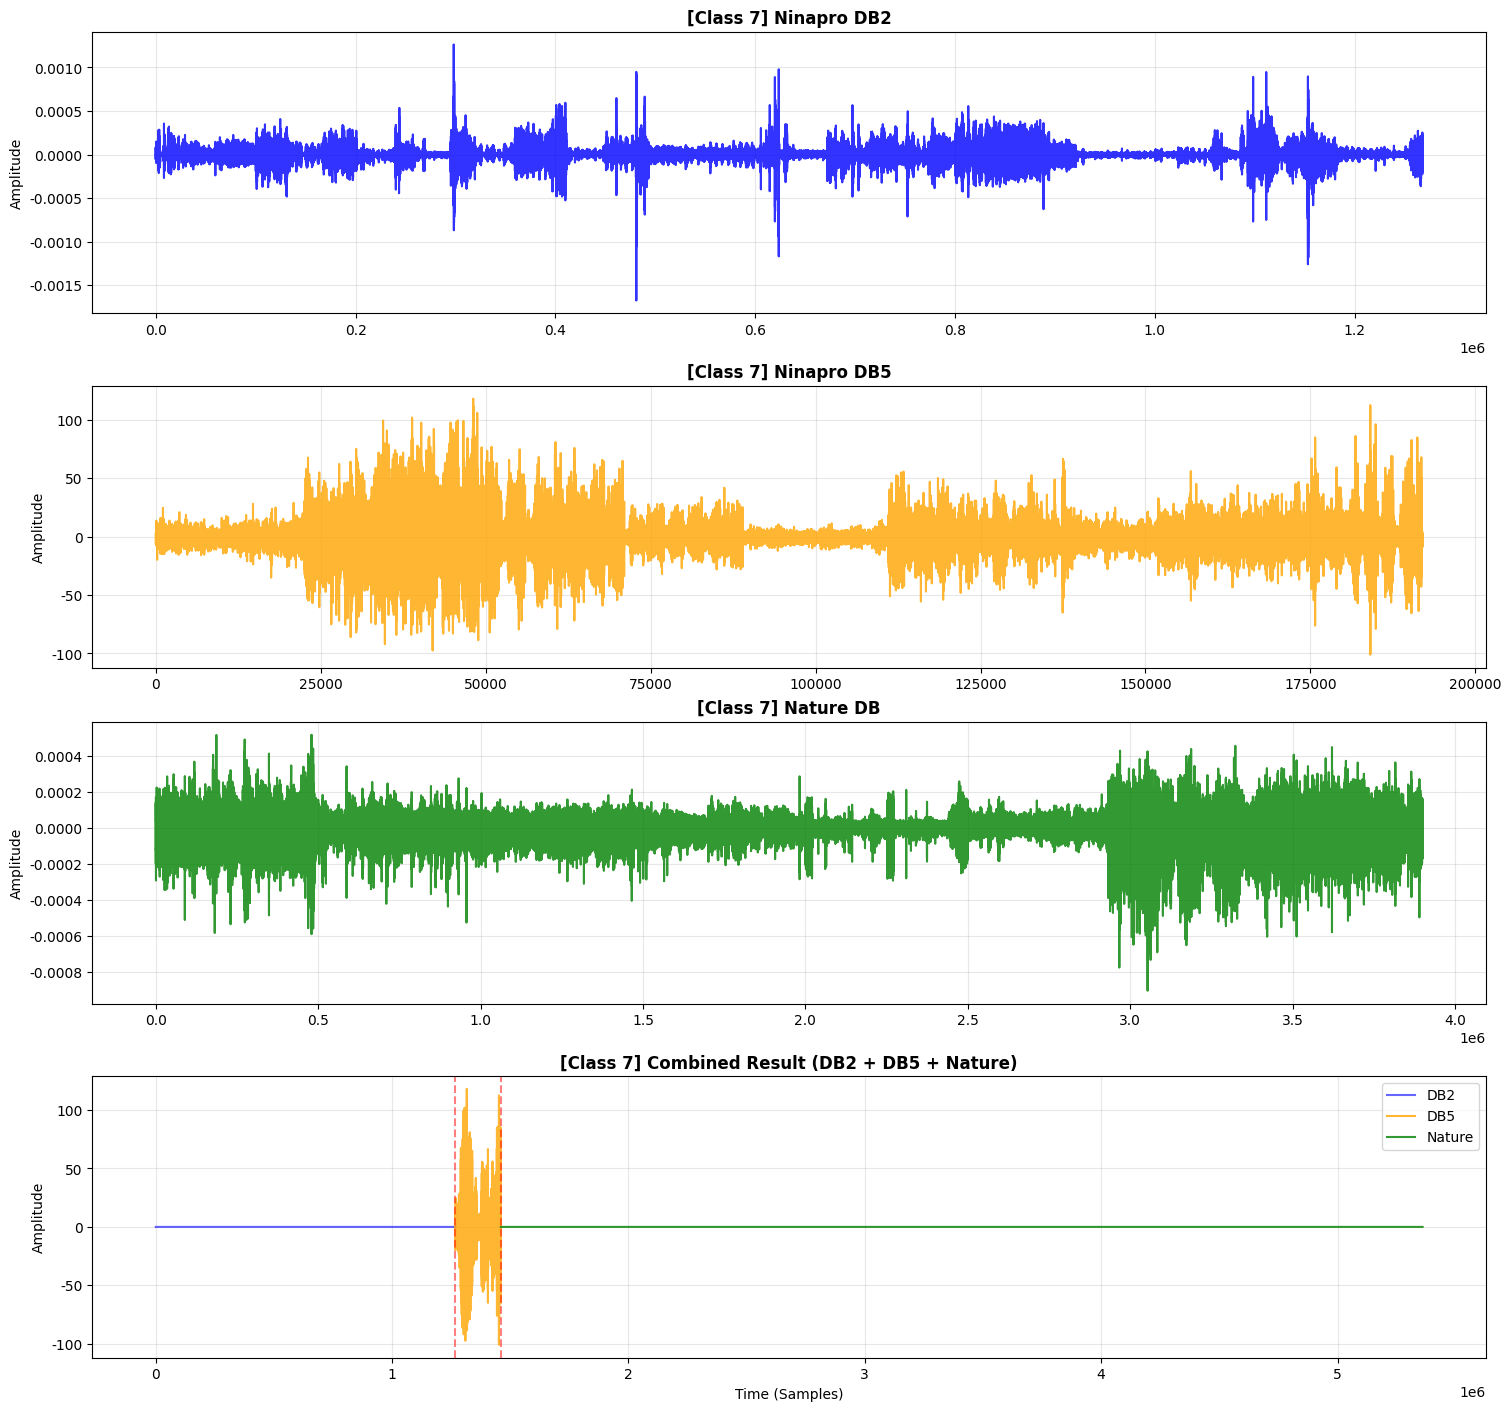

------------------------------------------------------------
Label 8 정보:
  - DB2   : 966000 samples (235 Groups)
  - DB5   : 182000 samples (60 Groups)
  - Nature: 0 samples (0 Groups)
  >>> 그래프 생성 중...


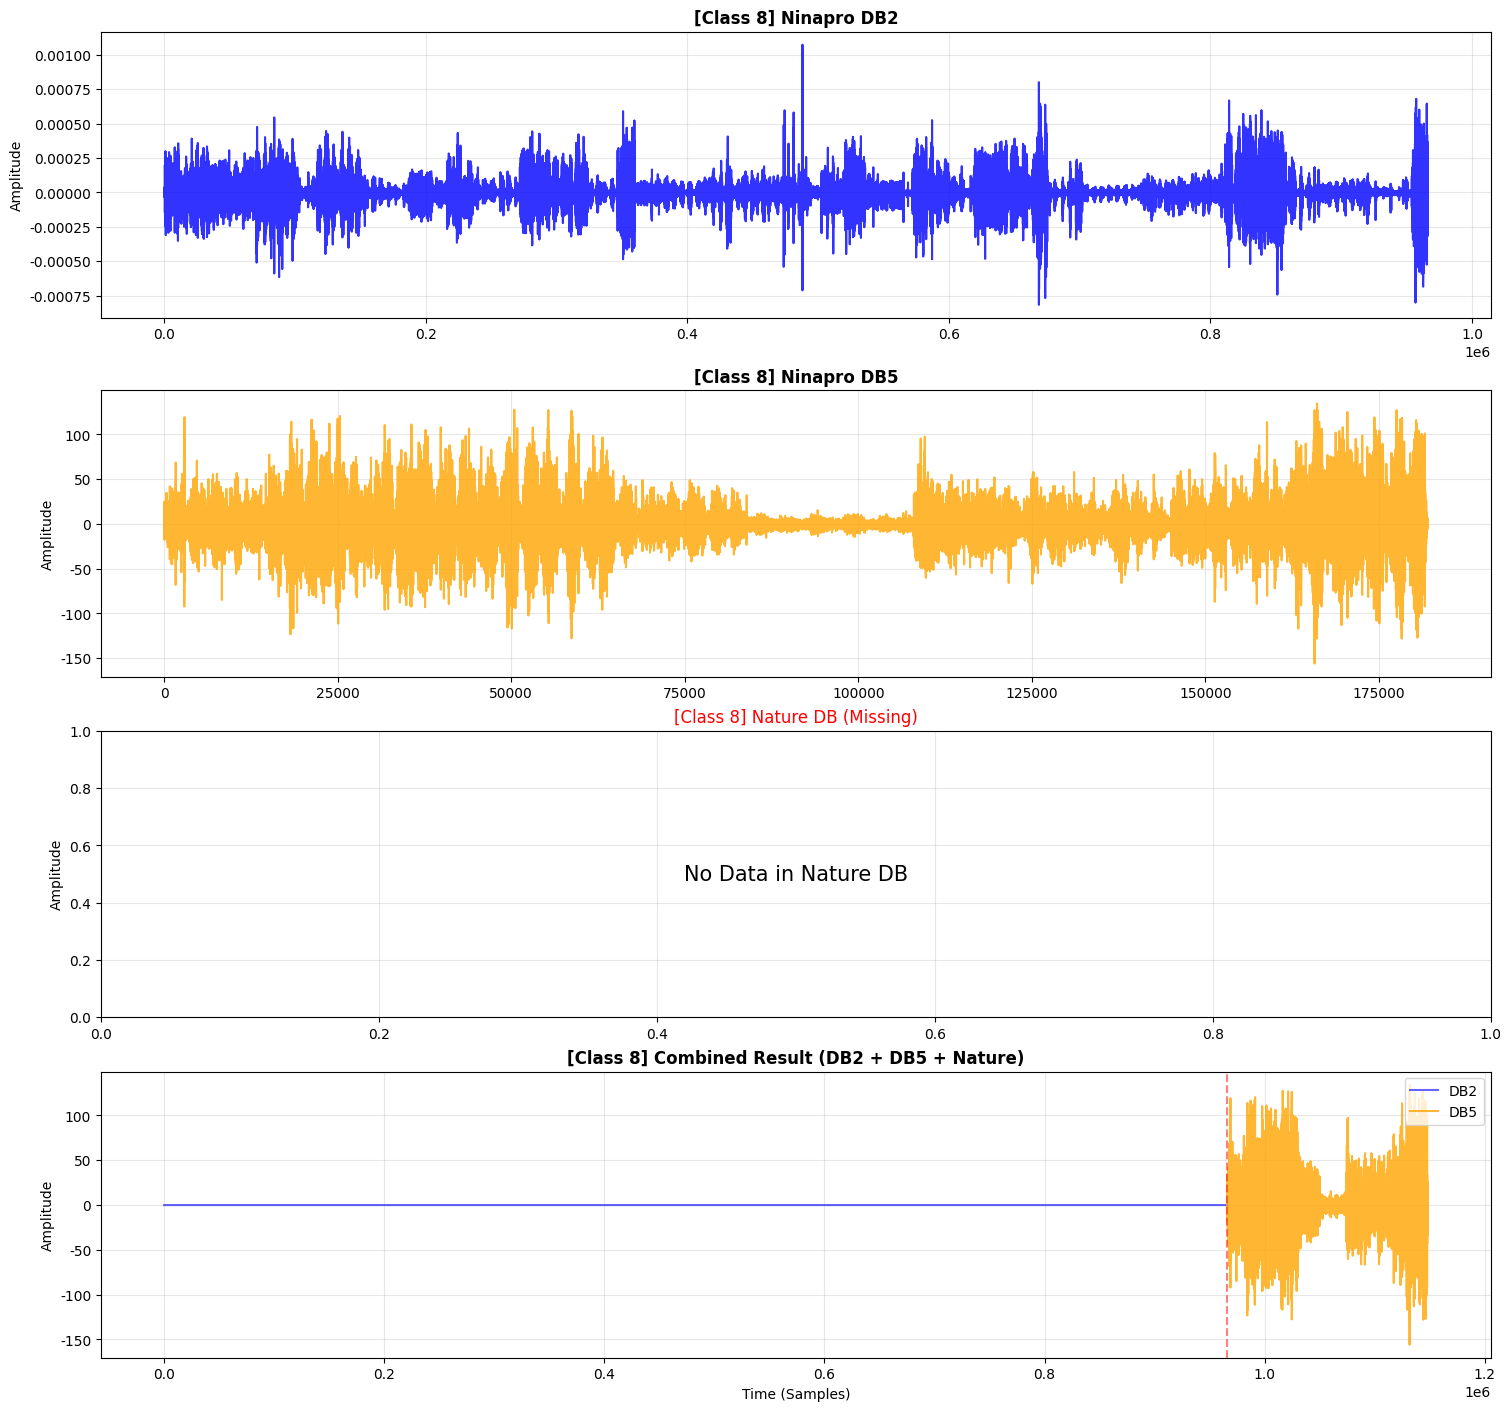

------------------------------------------------------------
Label 9 정보:
  - DB2   : 1050000 samples (239 Groups)
  - DB5   : 198000 samples (60 Groups)
  - Nature: 0 samples (0 Groups)
  >>> 그래프 생성 중...


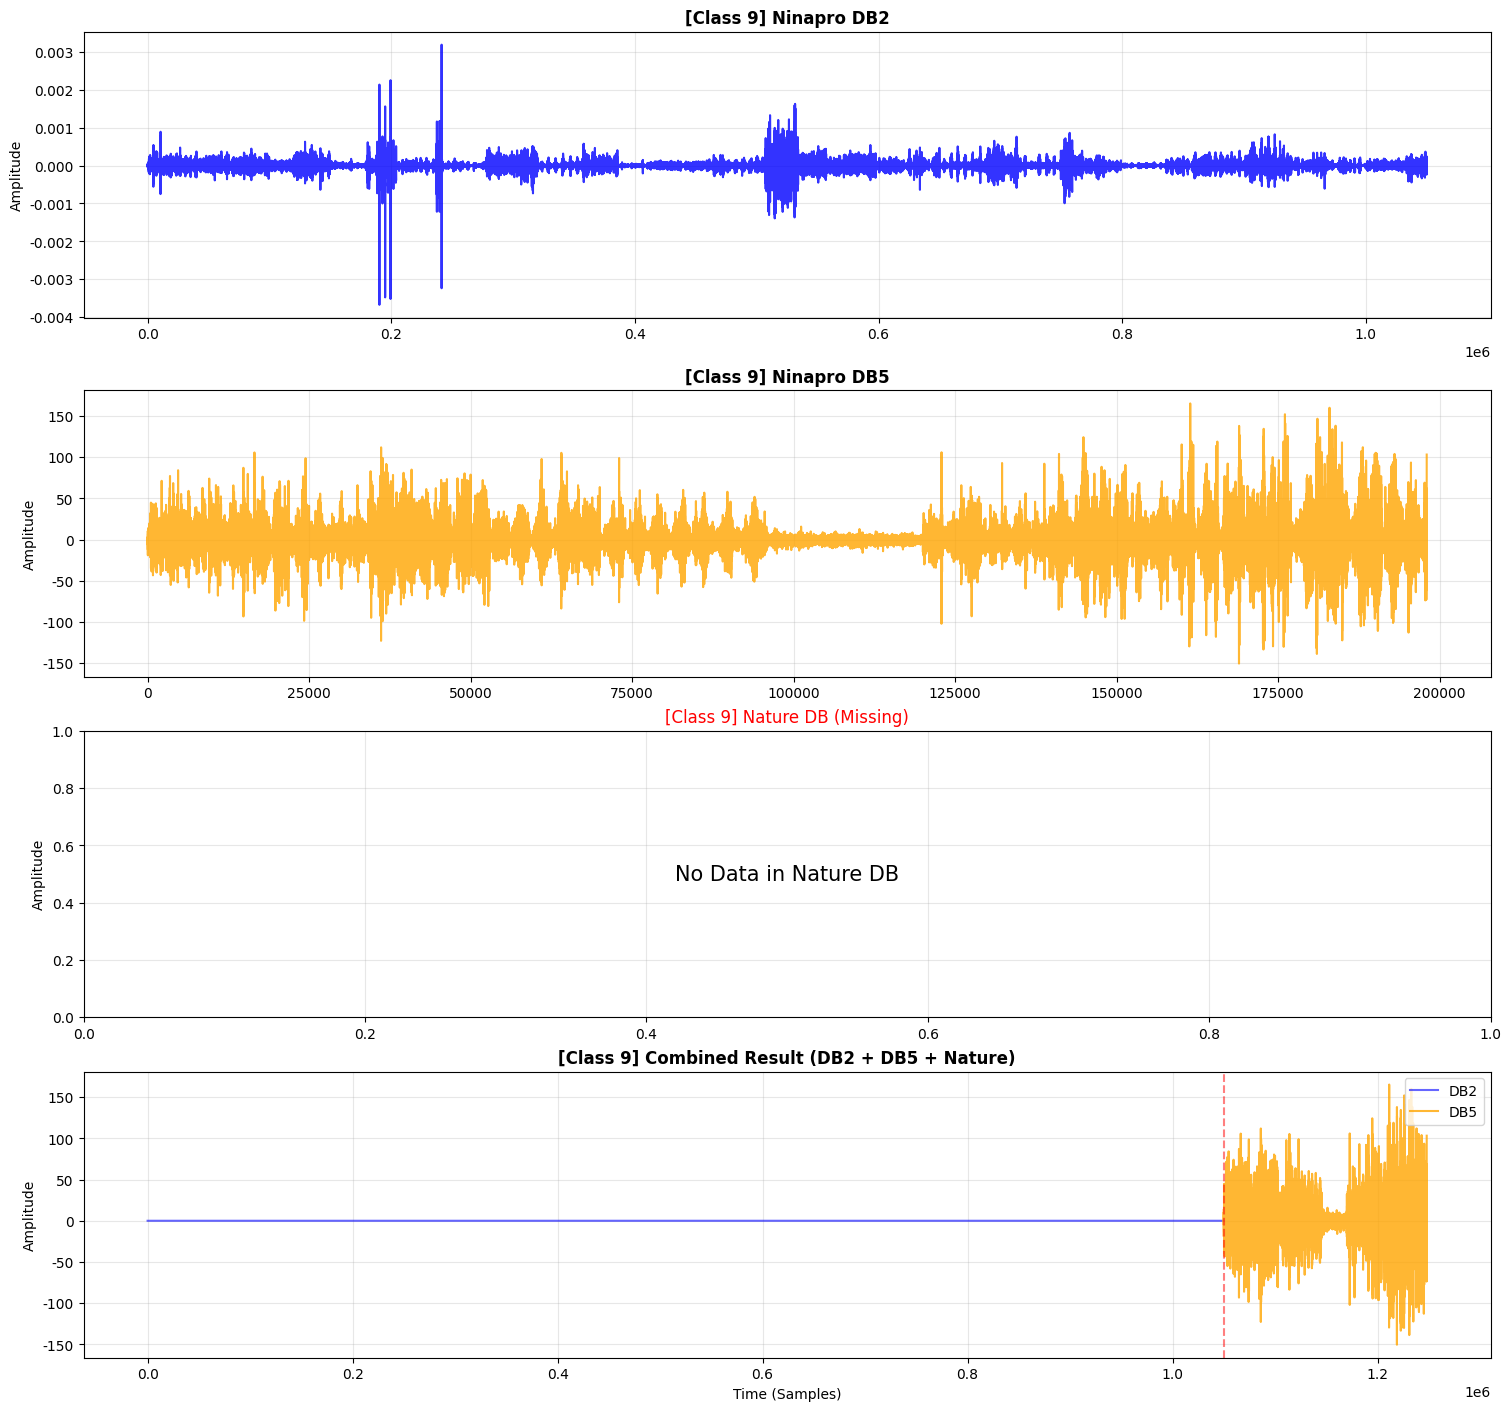

------------------------------------------------------------
Label 10 정보:
  - DB2   : 1034000 samples (235 Groups)
  - DB5   : 186000 samples (60 Groups)
  - Nature: 0 samples (0 Groups)
  >>> 그래프 생성 중...


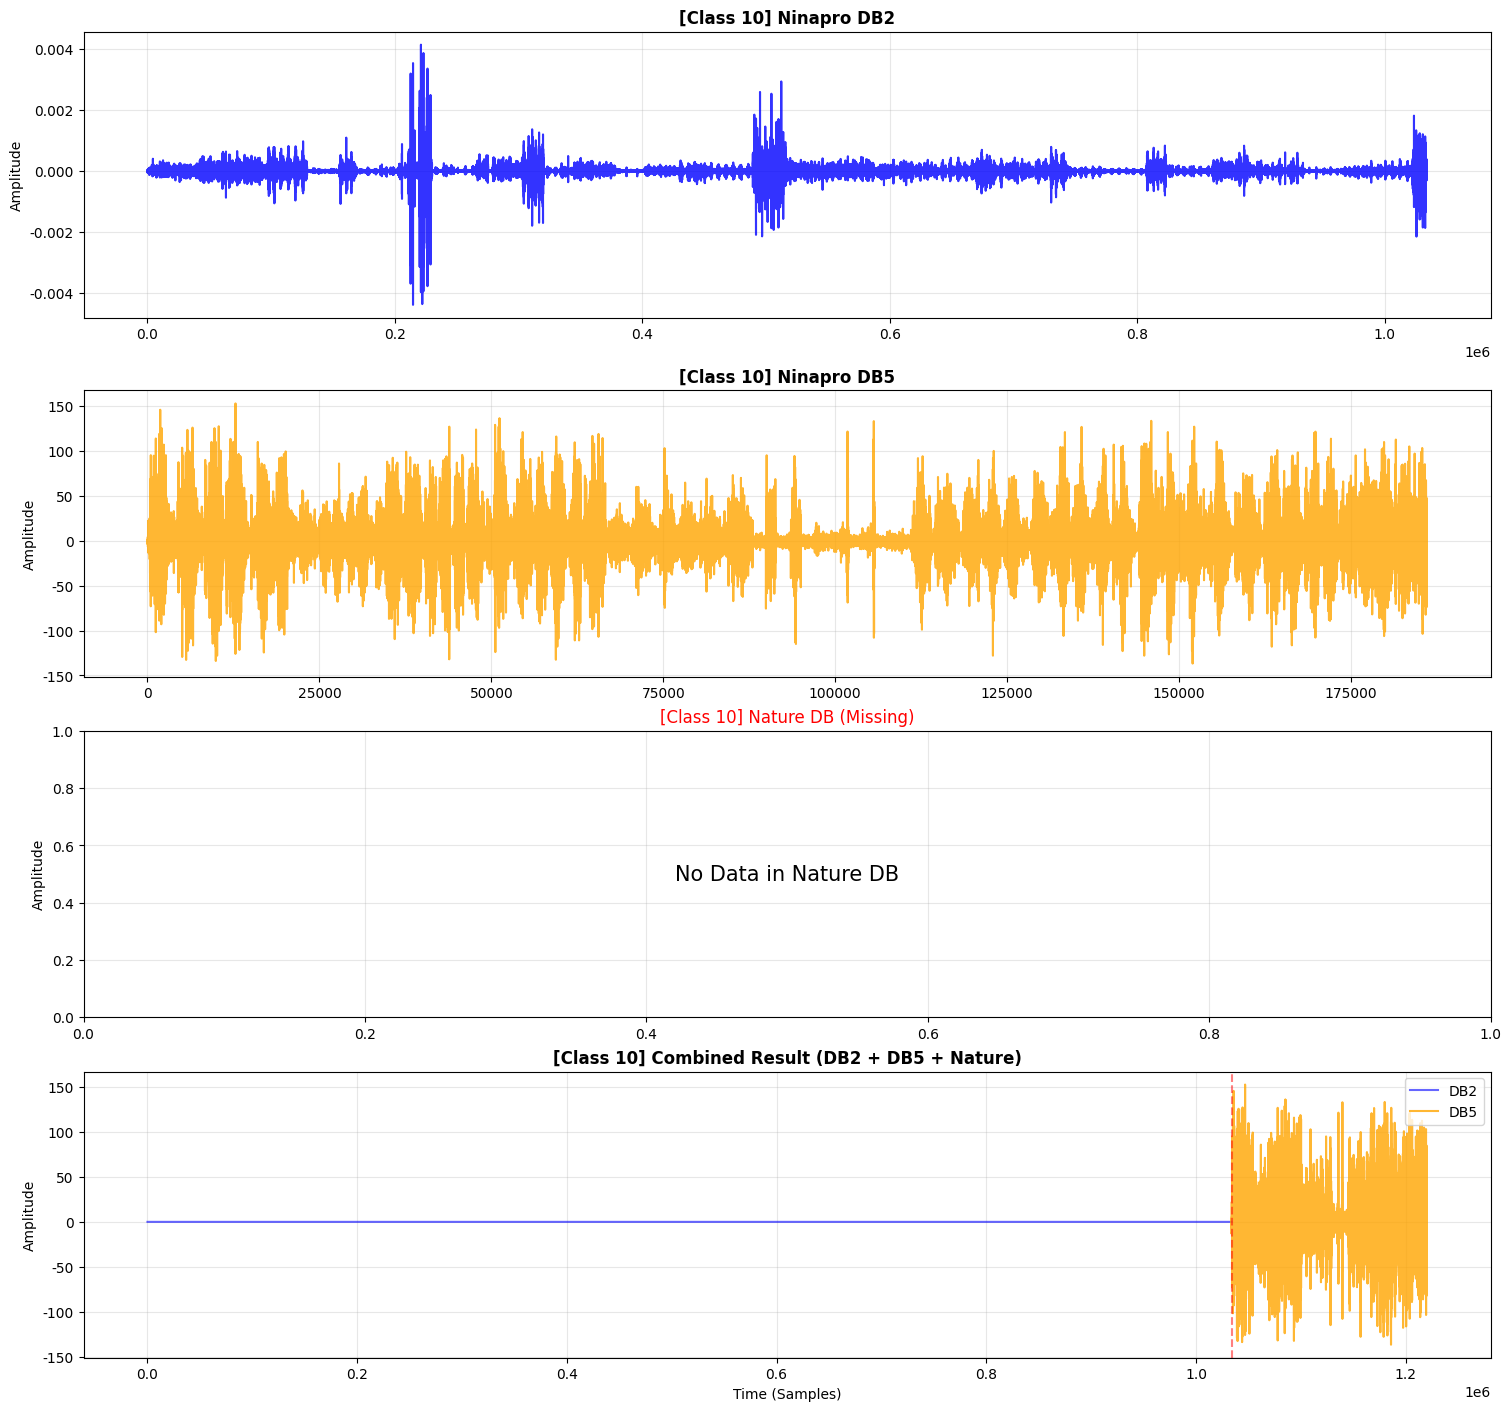

------------------------------------------------------------
Label 11 정보:
  - DB2   : 1156000 samples (240 Groups)
  - DB5   : 218000 samples (60 Groups)
  - Nature: 0 samples (0 Groups)
  >>> 그래프 생성 중...


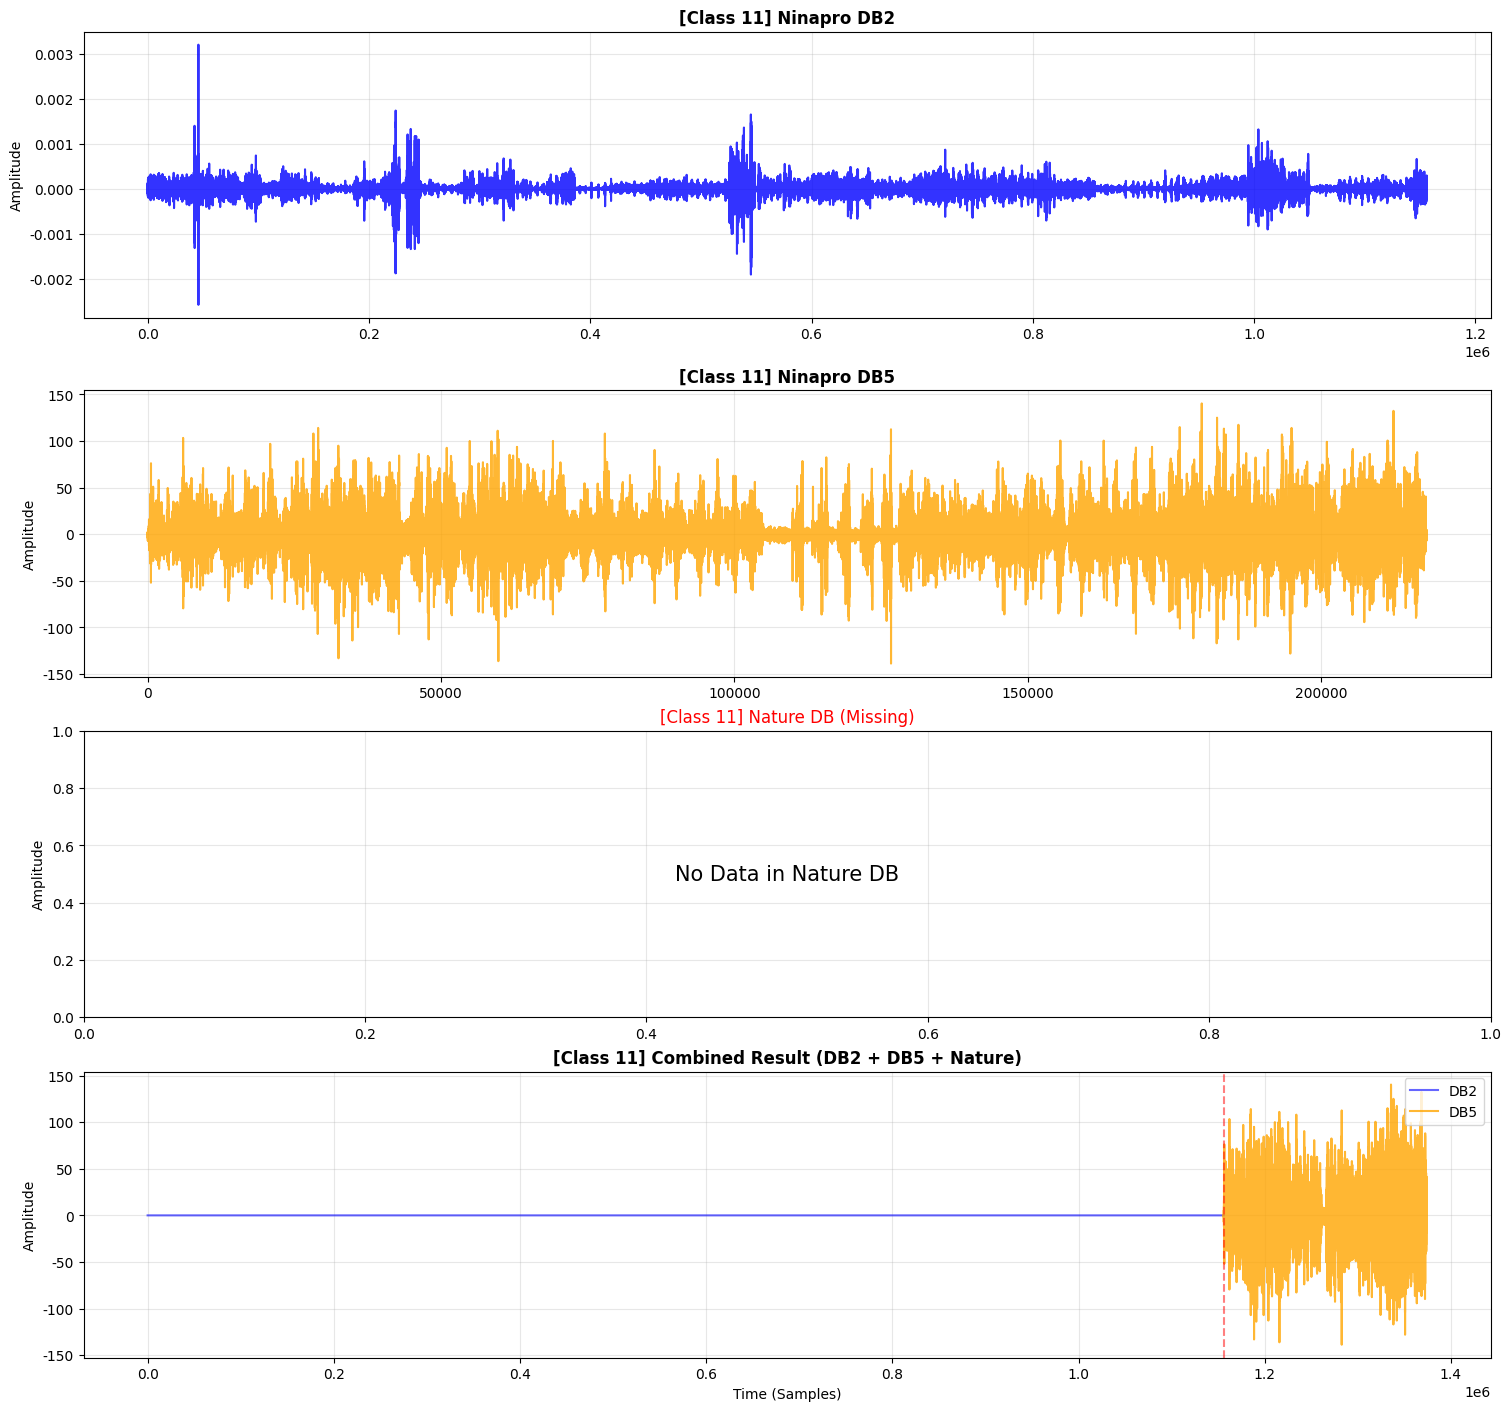

------------------------------------------------------------
Label 12 정보:
  - DB2   : 930000 samples (238 Groups)
  - DB5   : 194000 samples (60 Groups)
  - Nature: 0 samples (0 Groups)
  >>> 그래프 생성 중...


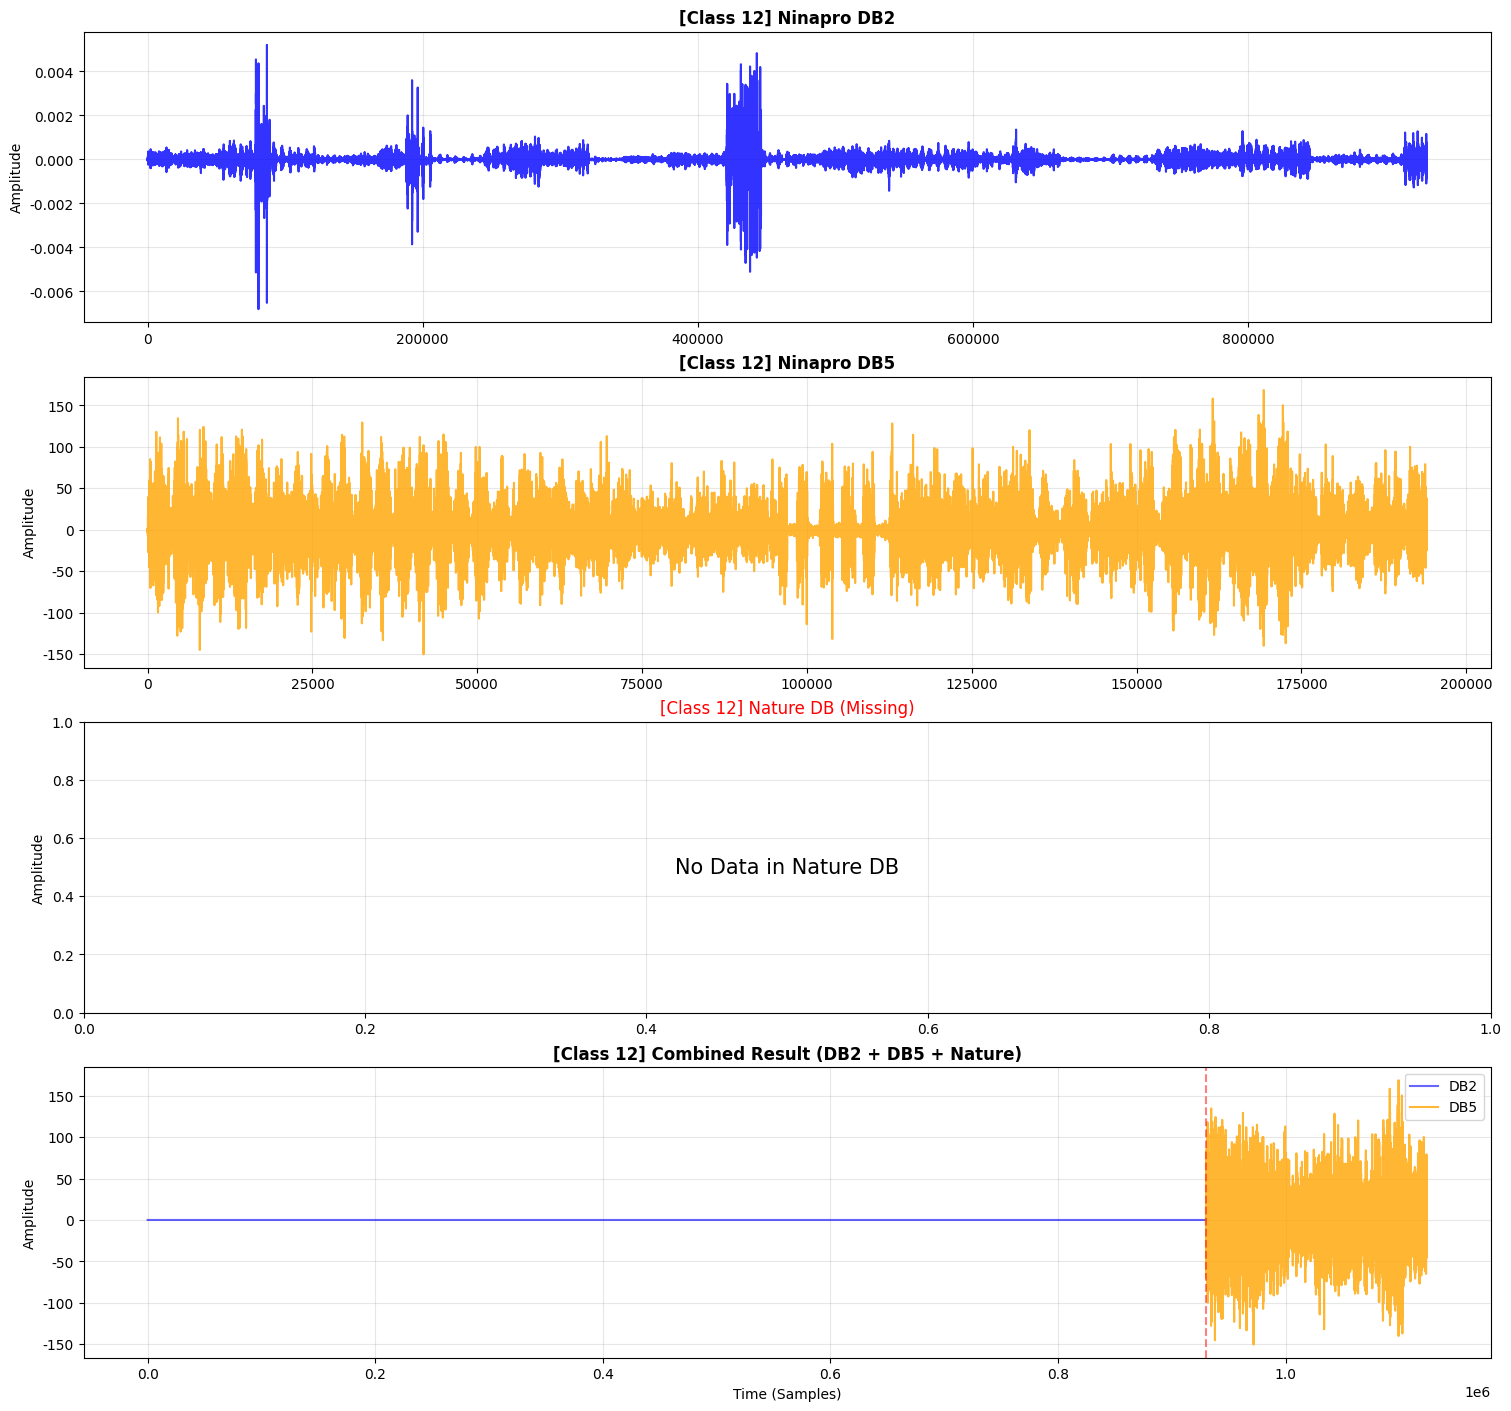

------------------------------------------------------------
Label 13 정보:
  - DB2   : 722000 samples (230 Groups)
  - DB5   : 194000 samples (60 Groups)
  - Nature: 0 samples (0 Groups)
  >>> 그래프 생성 중...


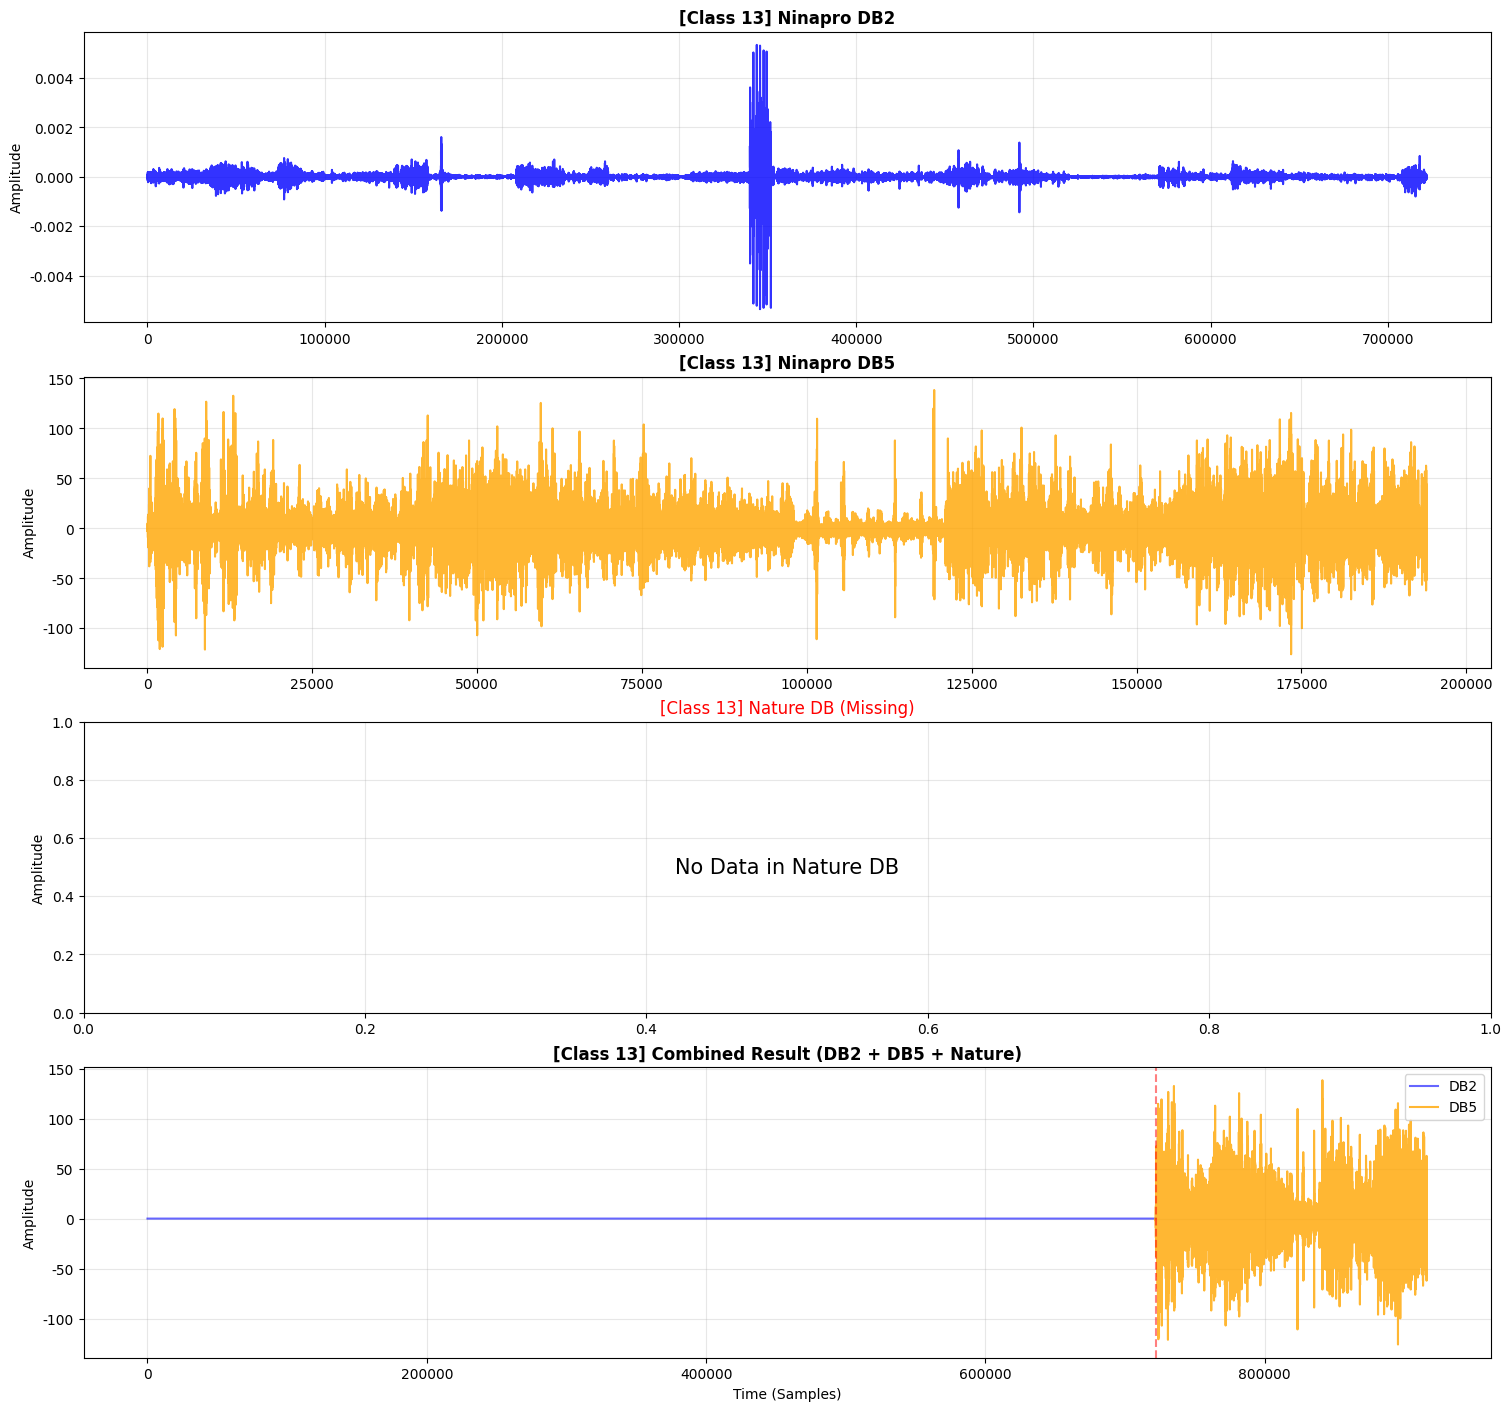

------------------------------------------------------------
Label 14 정보:
  - DB2   : 714000 samples (233 Groups)
  - DB5   : 168000 samples (60 Groups)
  - Nature: 0 samples (0 Groups)
  >>> 그래프 생성 중...


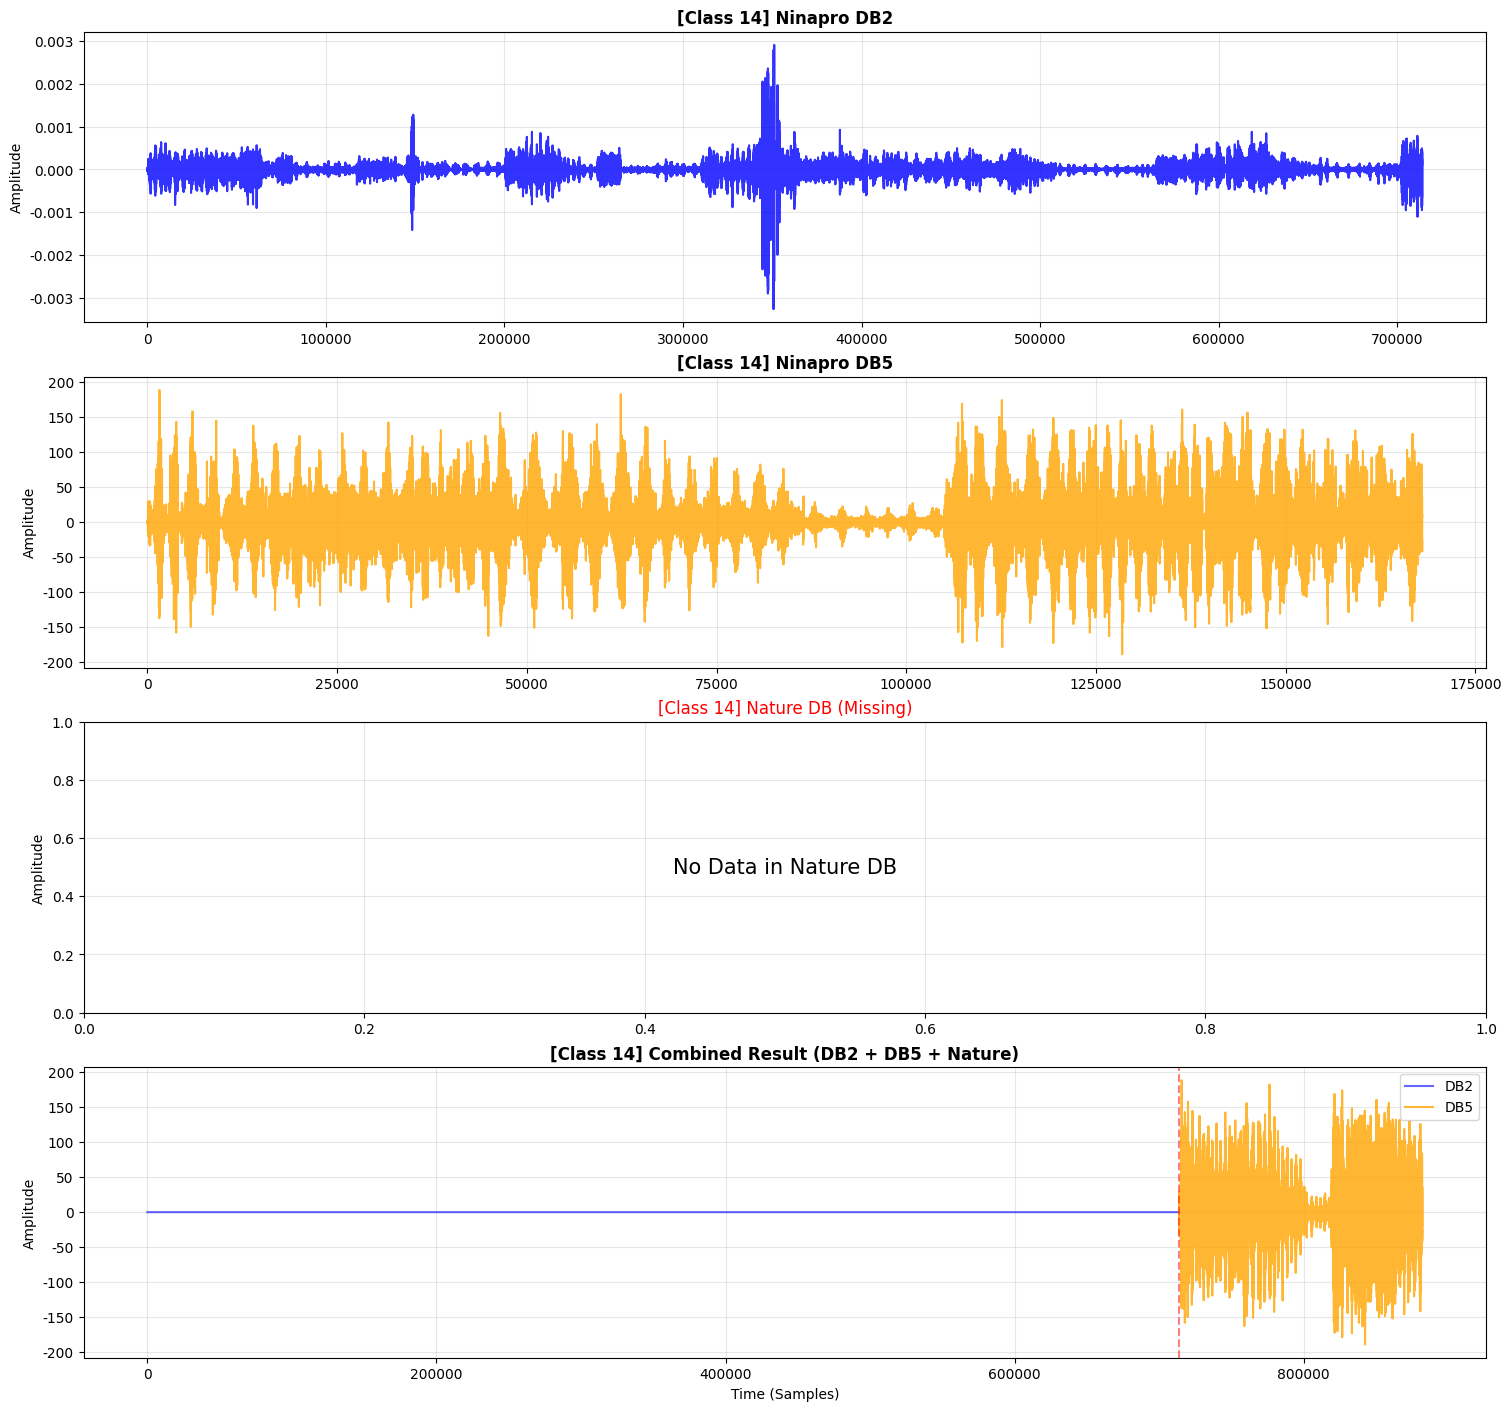

------------------------------------------------------------
Label 15 정보:
  - DB2   : 936000 samples (227 Groups)
  - DB5   : 150000 samples (60 Groups)
  - Nature: 0 samples (0 Groups)
  >>> 그래프 생성 중...


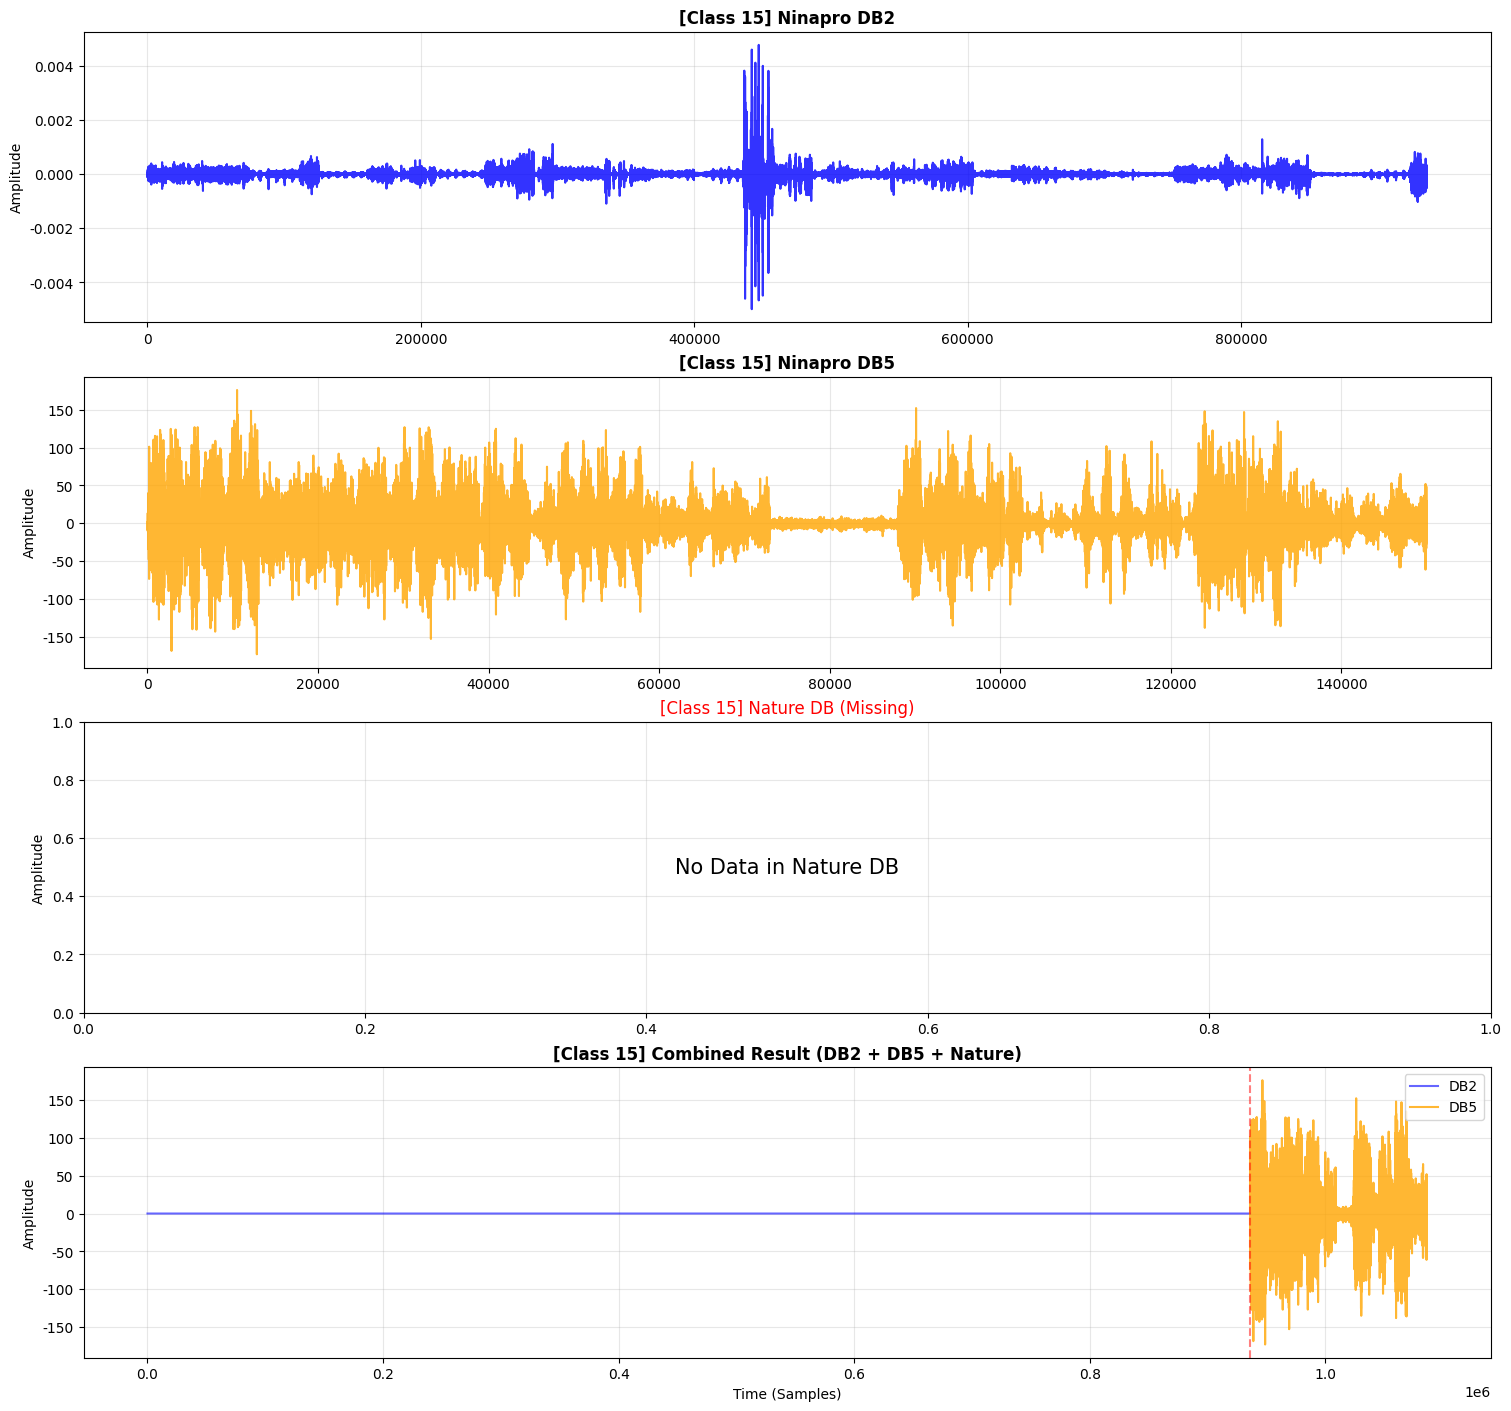

------------------------------------------------------------
Label 16 정보:
  - DB2   : 906000 samples (240 Groups)
  - DB5   : 224000 samples (60 Groups)
  - Nature: 0 samples (0 Groups)
  >>> 그래프 생성 중...


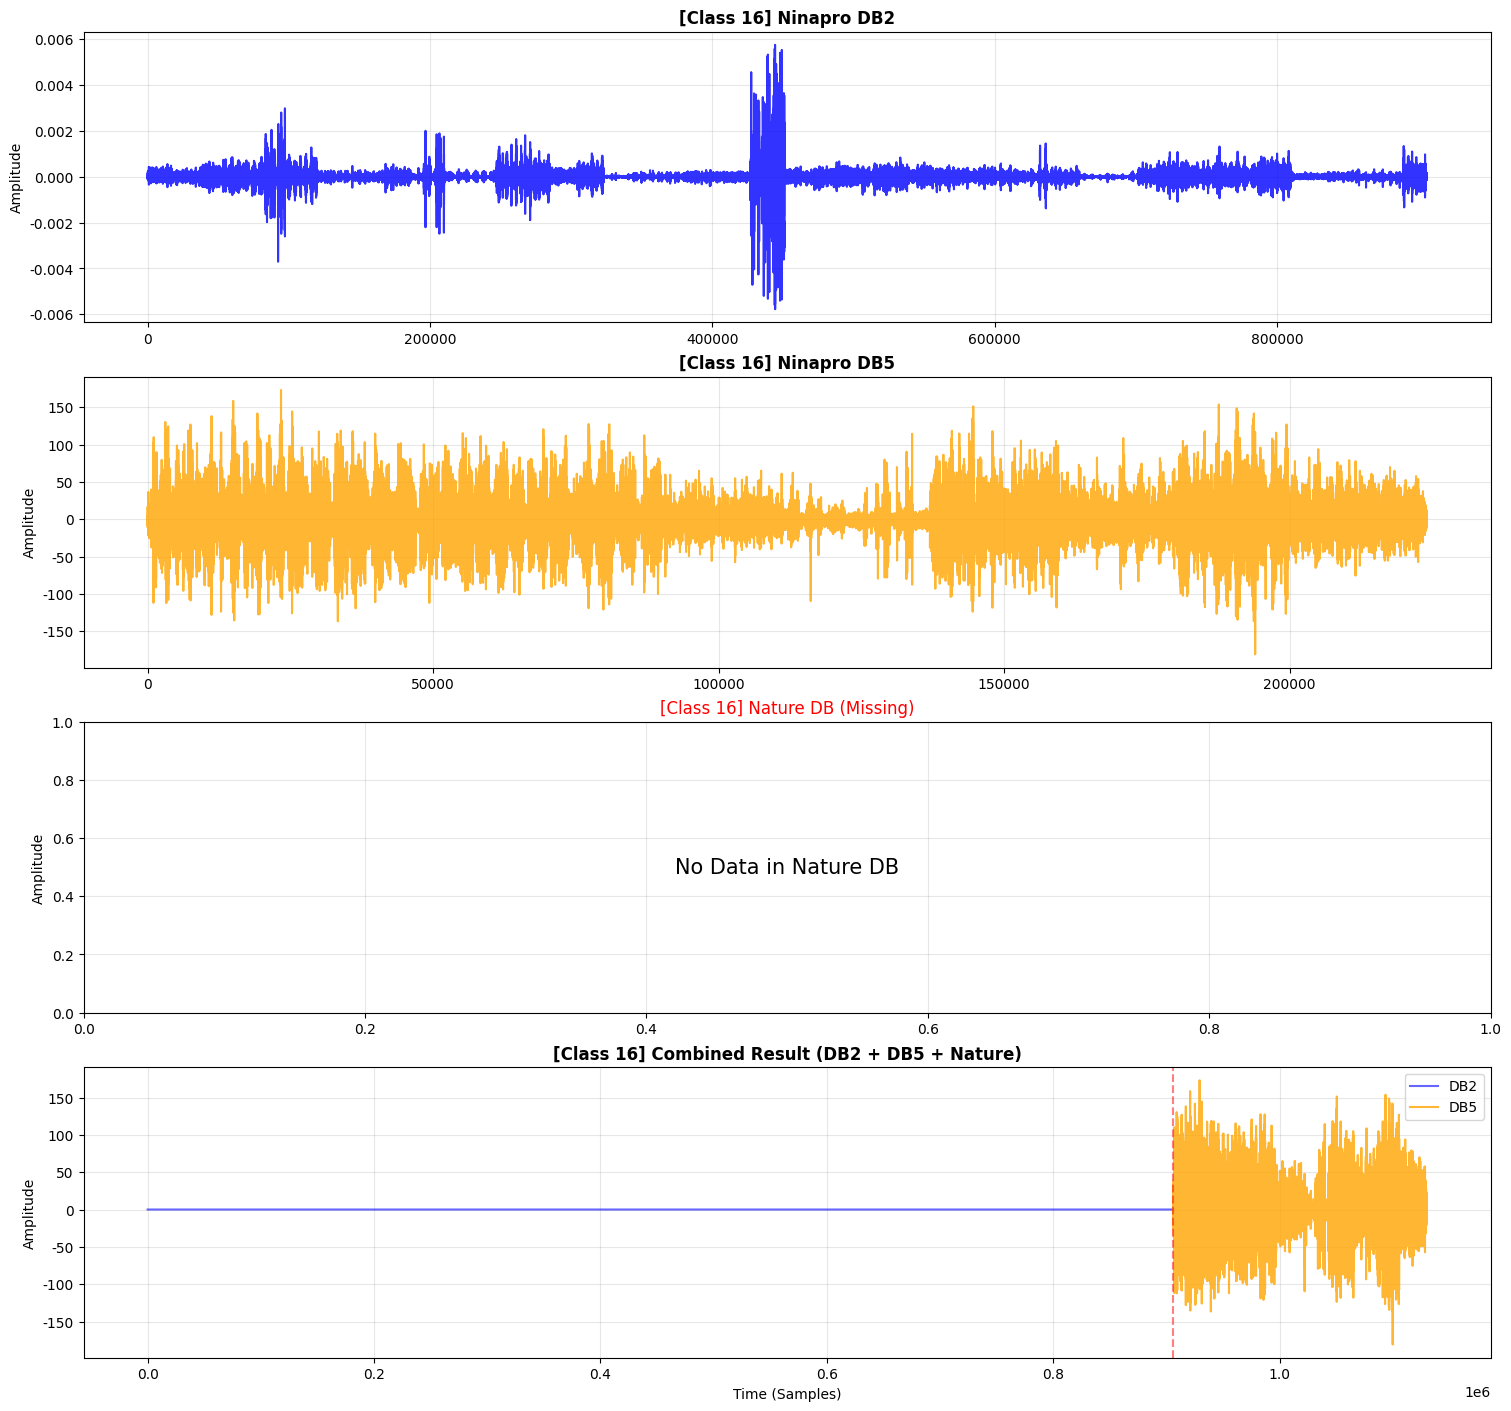

------------------------------------------------------------
Label 17 정보:
  - DB2   : 742000 samples (238 Groups)
  - DB5   : 202000 samples (60 Groups)
  - Nature: 0 samples (0 Groups)
  >>> 그래프 생성 중...


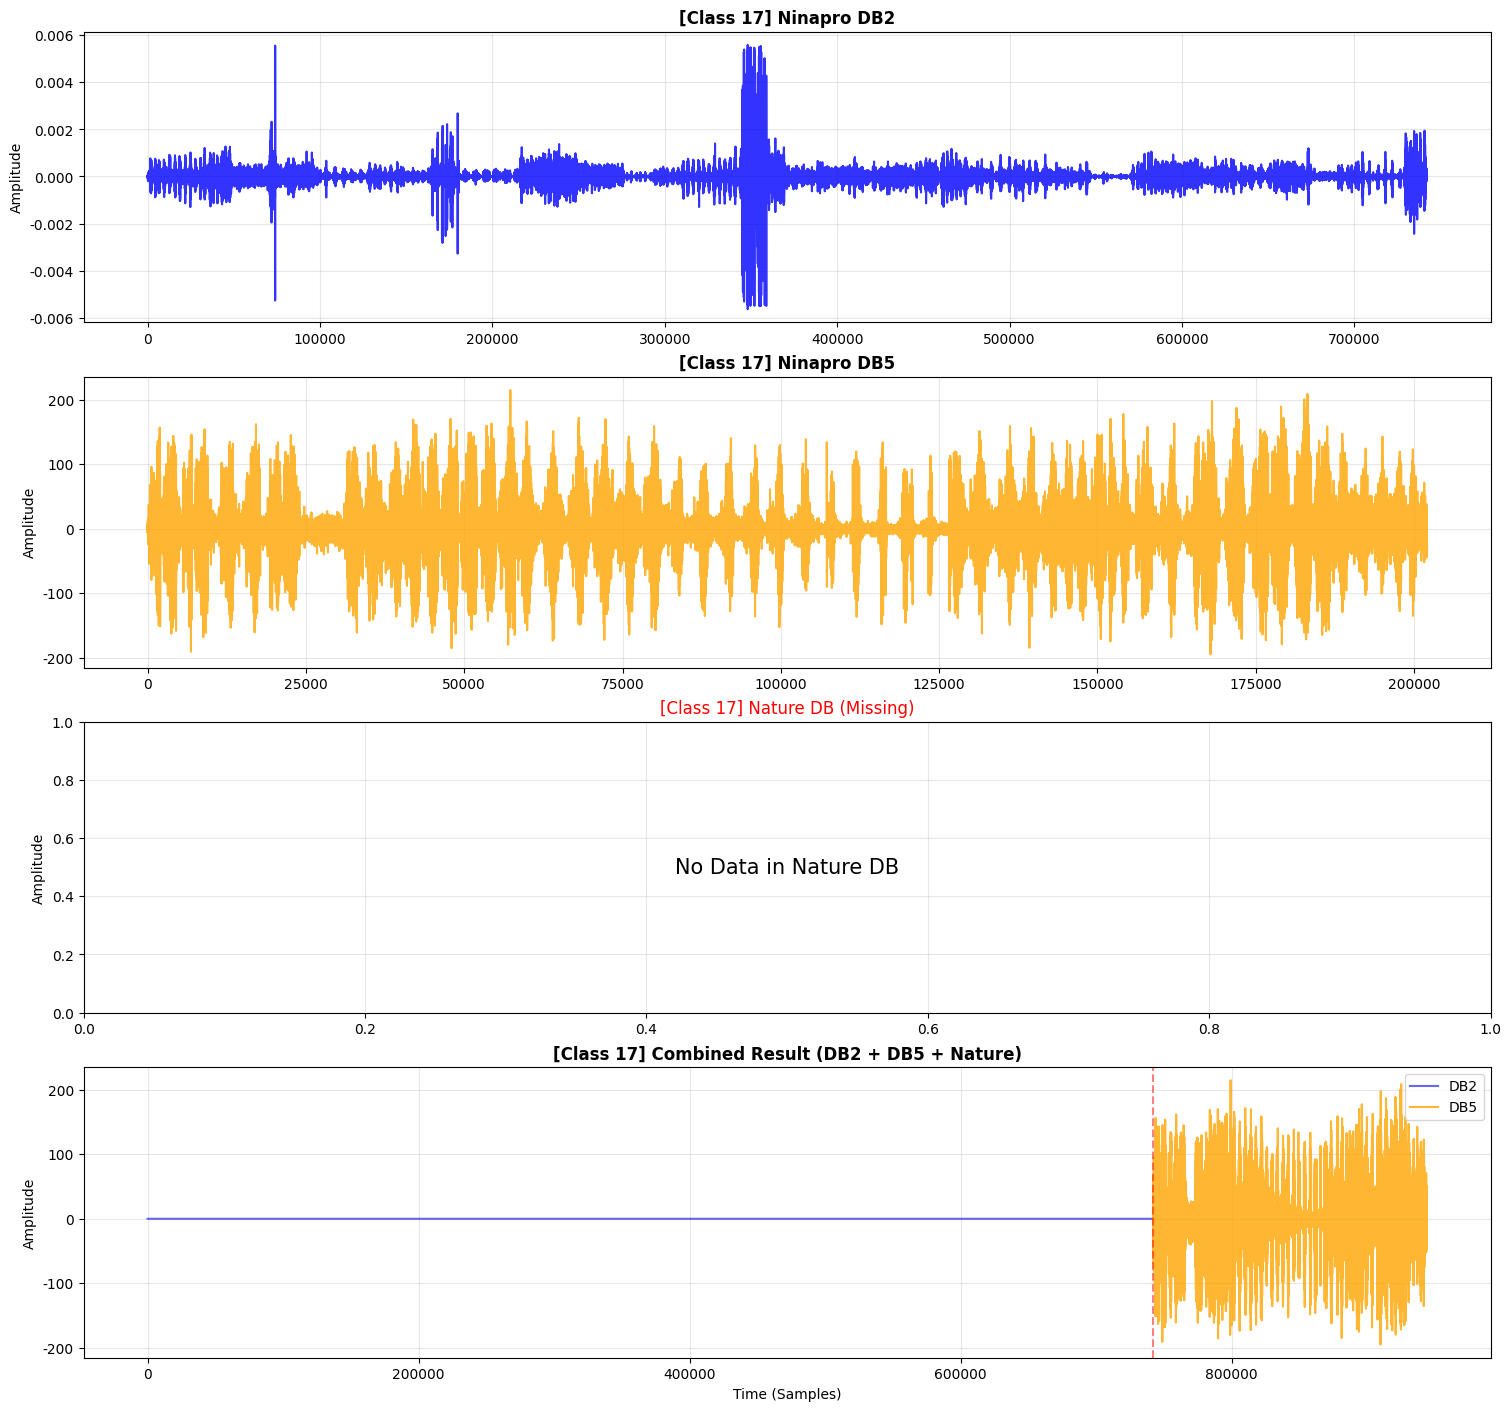

------------------------------------------------------------
Label 18 정보:
  - DB2   : 0 samples (0 Groups)
  - DB5   : 0 samples (0 Groups)
  - Nature: 3904000 samples (152 Groups)
  >>> 그래프 생성 중...


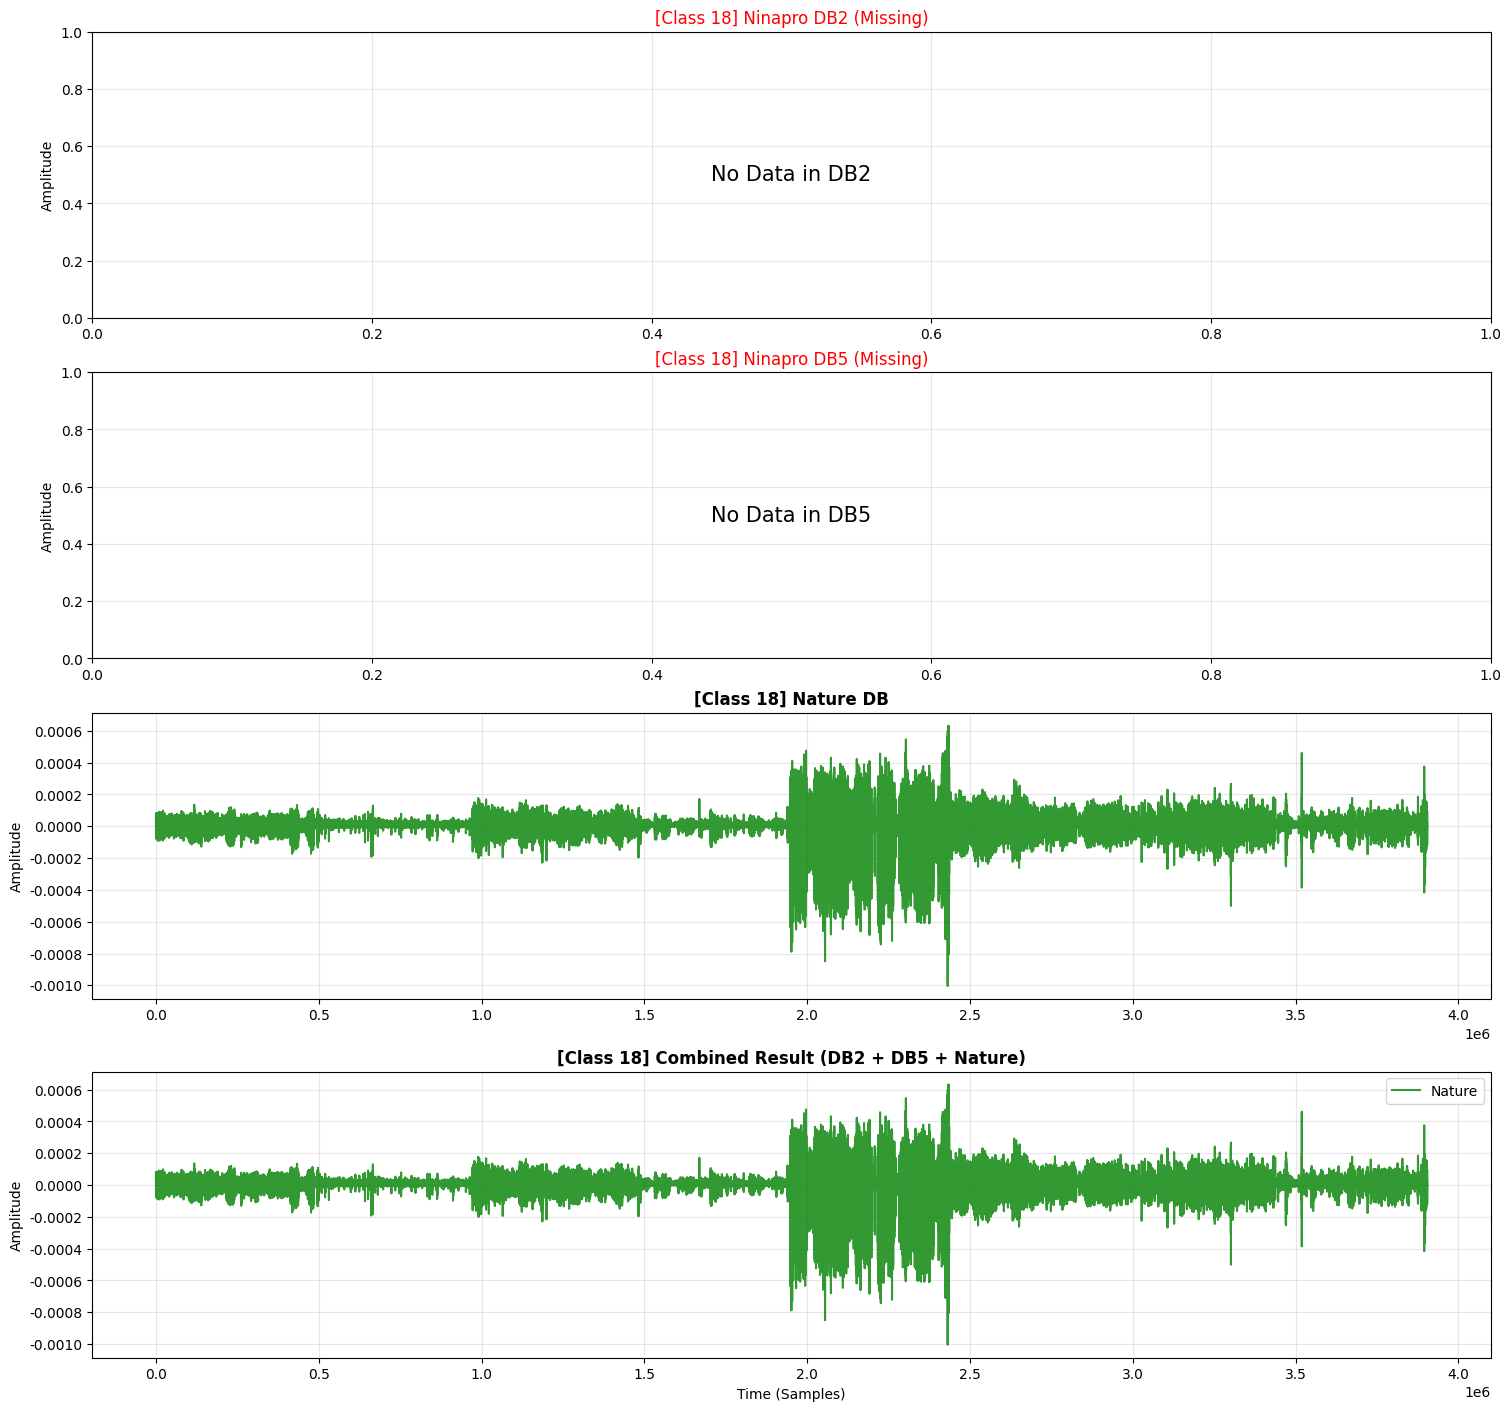

------------------------------------------------------------
Label 19 정보:
  - DB2   : 0 samples (0 Groups)
  - DB5   : 0 samples (0 Groups)
  - Nature: 3888000 samples (155 Groups)
  >>> 그래프 생성 중...


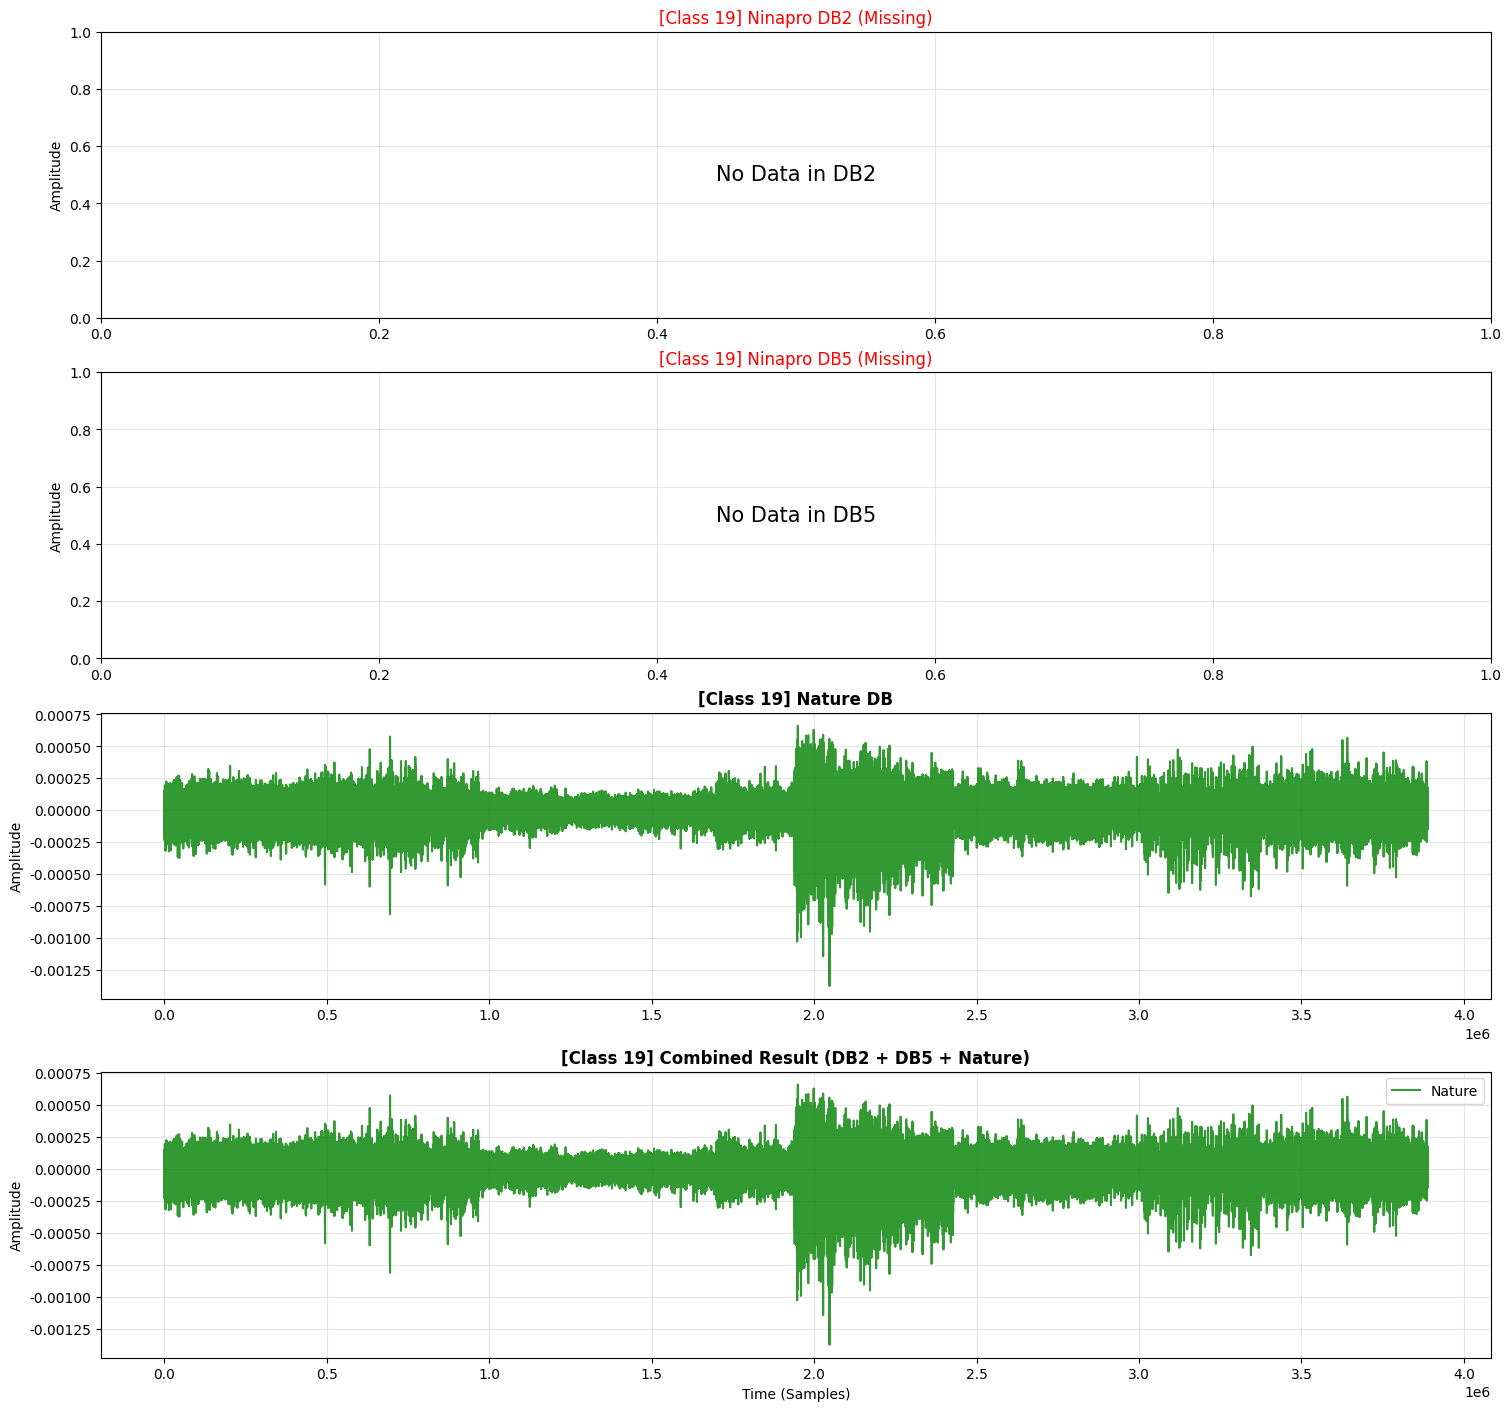

: 

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import logging

# [설정] 폰트 및 로그 차단
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR) 
plt.rcParams['font.family'] = 'sans-serif' 
plt.rcParams['axes.unicode_minus'] = False 

# ==========================================
# 1. 설정
# ==========================================
sensor_idx_to_plot = 0  

if 'ninapro_df2' in locals() and 'ninapro_df5' in locals() and 'nature_df' in locals():
    emg_columns = [col for col in ninapro_df2.columns if col != 'Restimulus']
    target_col_name = emg_columns[sensor_idx_to_plot]

    classes_df2 = set(ninapro_df2['Restimulus'].unique())
    classes_df5 = set(ninapro_df5['Restimulus'].unique())
    classes_nature = set(nature_df['Restimulus'].unique())
    all_classes = sorted(list(classes_df2 | classes_df5 | classes_nature)) 

    print(f"총 {len(all_classes)}개의 클래스를 발견했습니다: {all_classes}")

    # ==========================================
    # 2. 반복 시각화
    # ==========================================
    for target_class in all_classes:
        
        # --------------------------------------
        # 데이터 추출 및 그룹 카운팅
        # --------------------------------------
        raw_df2 = ninapro_df2[ninapro_df2['Restimulus'] == target_class]
        raw_df5 = ninapro_df5[ninapro_df5['Restimulus'] == target_class]
        raw_df_nature = nature_df[nature_df['Restimulus'] == target_class]
        
        groups_count_2 = 0
        if not raw_df2.empty:
            groups_count_2 = 1 + (raw_df2.index.to_series().diff() > 1).sum()
            
        groups_count_5 = 0
        if not raw_df5.empty:
            groups_count_5 = 1 + (raw_df5.index.to_series().diff() > 1).sum()

        groups_count_nature = 0
        if not raw_df_nature.empty:
            groups_count_nature = 1 + (raw_df_nature.index.to_series().diff() > 1).sum()

        # 인덱스 초기화
        df2_subset = raw_df2[target_col_name].reset_index(drop=True)
        df5_subset = raw_df5[target_col_name].reset_index(drop=True)
        dfnature_subset = raw_df_nature[target_col_name].reset_index(drop=True)
        
        if df2_subset.empty and df5_subset.empty and dfnature_subset.empty:
            continue

        # [수정] 출력 라벨 오류 수정 (DB5 -> Nature)
        print(f"-" * 60)
        print(f"Label {target_class} 정보:")
        print(f"  - DB2   : {len(df2_subset)} samples ({groups_count_2} Groups)")
        print(f"  - DB5   : {len(df5_subset)} samples ({groups_count_5} Groups)")
        print(f"  - Nature: {len(dfnature_subset)} samples ({groups_count_nature} Groups)")
        print(f"  >>> 그래프 생성 중...")

        # --------------------------------------
        # 그래프 그리기 ([수정] 4행으로 변경)
        # --------------------------------------
        # 행을 4개로 늘려 각각(DB2, DB5, Nature) 그리고 마지막에 합친 것(Merged)을 그림
        
        fig, axes = plt.subplots(4, 1, figsize=(15, 14), constrained_layout=True)
        
        # [1] DB2 Plot (axes[0])
        if not df2_subset.empty:
            axes[0].plot(df2_subset, color='blue', alpha=0.8)
            axes[0].set_title(f'[Class {target_class}] Ninapro DB2', fontsize=12, fontweight='bold')
        else:
            axes[0].text(0.5, 0.5, "No Data in DB2", ha='center', va='center', fontsize=15)
            axes[0].set_title(f'[Class {target_class}] Ninapro DB2 (Missing)', fontsize=12, color='red')
        axes[0].set_ylabel('Amplitude')
        axes[0].grid(True, alpha=0.3)

        # [2] DB5 Plot (axes[1])
        if not df5_subset.empty:
            axes[1].plot(df5_subset, color='orange', alpha=0.8)
            axes[1].set_title(f'[Class {target_class}] Ninapro DB5', fontsize=12, fontweight='bold')
        else:
            axes[1].text(0.5, 0.5, "No Data in DB5", ha='center', va='center', fontsize=15)
            axes[1].set_title(f'[Class {target_class}] Ninapro DB5 (Missing)', fontsize=12, color='red')
        axes[1].set_ylabel('Amplitude')
        axes[1].grid(True, alpha=0.3)

        # [3] Nature Plot (axes[2]) - [수정] 별도 axes 사용 및 오타 수정
        if not dfnature_subset.empty:
            axes[2].plot(dfnature_subset, color='green', alpha=0.8) # 색상 구분 (Green)
            axes[2].set_title(f'[Class {target_class}] Nature DB', fontsize=12, fontweight='bold')
        else:
            axes[2].text(0.5, 0.5, "No Data in Nature DB", ha='center', va='center', fontsize=15)
            axes[2].set_title(f'[Class {target_class}] Nature DB (Missing)', fontsize=12, color='red')
        axes[2].set_ylabel('Amplitude')
        axes[2].grid(True, alpha=0.3)

        # [4] Merged Result (axes[3]) - [수정] 인덱스 계산 로직 수정
        # DB2 그리기
        current_idx = 0
        if not df2_subset.empty:
            axes[3].plot(np.arange(len(df2_subset)), df2_subset, 
                        color='blue', alpha=0.6, label='DB2')
            current_idx += len(df2_subset)
        
        # DB5 그리기 (DB2 뒤에 이어서)
        if not df5_subset.empty:
            axes[3].plot(np.arange(current_idx, current_idx + len(df5_subset)), df5_subset, 
                        color='orange', alpha=0.8, label='DB5')
            if current_idx > 0:
                axes[3].axvline(x=current_idx, color='red', linestyle='--', alpha=0.5)
            current_idx += len(df5_subset)
    
        # Nature 그리기 (DB5 뒤에 이어서) - [수정] 시작 인덱스 업데이트 반영
        if not dfnature_subset.empty:
            axes[3].plot(np.arange(current_idx, current_idx + len(dfnature_subset)), dfnature_subset, 
                        color='green', alpha=0.8, label='Nature')
            if current_idx > 0:
                axes[3].axvline(x=current_idx, color='red', linestyle='--', alpha=0.5)

        axes[3].set_title(f'[Class {target_class}] Combined Result (DB2 + DB5 + Nature)', fontsize=12, fontweight='bold')
        axes[3].set_xlabel('Time (Samples)')
        axes[3].set_ylabel('Amplitude')
        axes[3].legend(loc='upper right')
        axes[3].grid(True, alpha=0.3)

        plt.show() 
else:
    print("오류: 데이터프레임(ninapro_df2, ninapro_df5, nature_df)이 정의되지 않았습니다.")

In [7]:
import pandas as pd

def print_max_min_exclude_zero(df, df_name):
    # 1. 연속된 그룹 식별 ID 생성
    group_id = (df['Restimulus'] != df['Restimulus'].shift()).cumsum()
    
    # 2. 그룹별 길이(size)와 라벨값(first) 추출
    group_info = df.groupby(group_id)['Restimulus'].agg(['size', 'first'])
    
    # -------------------------------------------------------
    # [기능 추가] Label 0 제외 필터링
    # -------------------------------------------------------
    # 라벨이 0이 아닌 그룹만 남깁니다.
    target_groups = group_info[group_info['first'] != 0]
    
    if target_groups.empty:
        print(f"[{df_name}] Label 0을 제외하면 남는 데이터가 없습니다.")
        return

    # 3. 최대/최소값 찾기 (필터링된 데이터 기준)
    max_len = target_groups['size'].max()
    min_len = target_groups['size'].min()
    
    # 해당 길이의 라벨 찾기
    max_label = target_groups.loc[target_groups['size'].idxmax(), 'first']
    min_label = target_groups.loc[target_groups['size'].idxmin(), 'first']
    
    print(f"📊 [{df_name}] 분석 결과 (Label 0 제외)")
    print(f"----------------------------------------")
    print(f"최대 길이: {max_len} (Label: {max_label})")
    print(f"최소 길이: {min_len} (Label: {min_label})")
    print(f"분석된 그룹 수: {len(target_groups)} (전체 {len(group_info)}개 중)")
    print(f"----------------------------------------\n")

# --- 실행 ---
print_max_min_exclude_zero(ninapro_df2, "ninapro_df2")
print_max_min_exclude_zero(ninapro_df5, "ninapro_df5")
print_max_min_exclude_zero(nature_df, "nature_df")


📊 [ninapro_df2] 분석 결과 (Label 0 제외)
----------------------------------------
최대 길이: 7000 (Label: 1)
최소 길이: 1000 (Label: 6)
분석된 그룹 수: 4080 (전체 8161개 중)
----------------------------------------

📊 [ninapro_df5] 분석 결과 (Label 0 제외)
----------------------------------------
최대 길이: 7000 (Label: 17)
최소 길이: 2000 (Label: 6)
분석된 그룹 수: 1020 (전체 2041개 중)
----------------------------------------

📊 [nature_df] 분석 결과 (Label 0 제외)
----------------------------------------
최대 길이: 50000 (Label: 18)
최소 길이: 24000 (Label: 7)
분석된 그룹 수: 783 (전체 815개 중)
----------------------------------------



In [8]:
import pandas as pd

def force_fixed_length_with_stitching(df, target_length=2000):
    """
    모든 그룹을 target_length로 만듭니다.
    - 긴 경우: 2000개 자르고, 남은 것은 '대기열(Buffer)'에 넣습니다.
    - 짧은 경우: '대기열'에 있는 데이터와 합쳐서 2000을 만듭니다.
    - 그래도 부족하면: 다음 데이터가 올 때까지 대기열에서 기다립니다.
    """
    # 1. 그룹 식별
    group_id = (df['Restimulus'] != df['Restimulus'].shift()).cumsum()
    
    processed_list = []
    
    # [핵심] 라벨별로 자투리 데이터를 모아둘 저장소 (Dictionary)
    # 예: { Label_1: DataFrame, Label_2: DataFrame ... }
    label_buffer = {}
    
    print(f"--- 길이 고정 및 이어붙이기 작업 시작 (Target: {target_length}) ---")
    
    # 2. 그룹별 순회
    for gid, segment in df.groupby(group_id):
        label = segment['Restimulus'].iloc[0] # 현재 그룹의 동작 라벨
        
        # (1) 해당 라벨의 버퍼가 비어있으면 새로 생성
        if label not in label_buffer:
            label_buffer[label] = pd.DataFrame()
            
        # (2) 현재 구간을 버퍼(대기열) 뒤에 추가
        #     이전 그룹에서 남은 자투리 뒤에 현재 데이터를 붙이는 개념
        label_buffer[label] = pd.concat([label_buffer[label], segment])
        
        # (3) 버퍼에 데이터가 2000개 이상 쌓였는지 확인 (반복)
        while len(label_buffer[label]) >= target_length:
            # 2000개만큼 뚝 떼어내기
            complete_segment = label_buffer[label].iloc[:target_length].copy()
            
            # 인덱스 깔끔하게 초기화 (0 ~ 1999)
            complete_segment = complete_segment.reset_index(drop=True)
            
            # 결과 리스트에 저장
            processed_list.append(complete_segment)
            
            # 버퍼 업데이트 (앞에 쓴 2000개는 버리고 남은 뒷부분만 남김)
            label_buffer[label] = label_buffer[label].iloc[target_length:]
            
    # 3. 병합 및 반환
    if processed_list:
        new_df = pd.concat(processed_list).reset_index(drop=True)
        
        # 통계 출력
        print(f"-> 처리 완료. 생성된 2000길이 샘플 수: {len(processed_list)}개")
        
        # (선택사항) 아직 버퍼에 남아서 2000이 안 되어 버려진 데이터 확인
        total_leftover = sum([len(buf) for buf in label_buffer.values()])
        print(f"-> (참고) 짝을 못 맞춰 버려진 자투리 데이터 총합: {total_leftover}개")
        
        return new_df
    else:
        return pd.DataFrame(columns=df.columns)

# ---------------------------------------------------------
# 실행 및 결과 저장
# ---------------------------------------------------------

# ninapro_df2 적용
print("\nProcessing 'ninapro_df2'...")
ninapro_df2 = force_fixed_length_with_stitching(ninapro_df2, target_length=2000)

# ninapro_df5 적용
print("\nProcessing 'ninapro_df5'...")
ninapro_df5 = force_fixed_length_with_stitching(ninapro_df5, target_length=2000)

# nature_df 적용
print("\nProcessing 'nature_df'...")
nature_df = force_fixed_length_with_stitching(nature_df, target_length=2000)

# ---------------------------------------------------------
# 결과 검증
# ---------------------------------------------------------
def check_length_stats(df, name):
    if len(df) == 0:
        print(f"[{name}] 데이터가 없습니다.")
        return
    # 이제 단순히 Restimulus로 묶으면 안되고(이어붙여서 섞였을 수 있음), 
    # 인덱스나 개수로 확인해야 합니다. 여기서는 전체 길이를 2000으로 나눠서 확인.
    
    total_len = len(df)
    is_perfect = (total_len % 2000) == 0
    
    print(f"\n📊 [{name}] 최종 검증")
    print(f"  - 전체 데이터 길이: {total_len}")
    print(f"  - 2000 단위로 딱 떨어집니까? : {is_perfect}")
    if is_perfect:
        print(f"  - 총 샘플 개수: {total_len // 2000}개")

check_length_stats(ninapro_df2, "ninapro_df2")
check_length_stats(ninapro_df5, "ninapro_df5")
check_length_stats(nature_df, "nature_df")


Processing 'ninapro_df2'...
--- 길이 고정 및 이어붙이기 작업 시작 (Target: 2000) ---
-> 처리 완료. 생성된 2000길이 샘플 수: 16016개
-> (참고) 짝을 못 맞춰 버려진 자투리 데이터 총합: 8000개

Processing 'ninapro_df5'...
--- 길이 고정 및 이어붙이기 작업 시작 (Target: 2000) ---
-> 처리 완료. 생성된 2000길이 샘플 수: 4547개
-> (참고) 짝을 못 맞춰 버려진 자투리 데이터 총합: 9000개

Processing 'nature_df'...
--- 길이 고정 및 이어붙이기 작업 시작 (Target: 2000) ---
-> 처리 완료. 생성된 2000길이 샘플 수: 11731개
-> (참고) 짝을 못 맞춰 버려진 자투리 데이터 총합: 4000개

📊 [ninapro_df2] 최종 검증
  - 전체 데이터 길이: 32032000
  - 2000 단위로 딱 떨어집니까? : True
  - 총 샘플 개수: 16016개

📊 [ninapro_df5] 최종 검증
  - 전체 데이터 길이: 9094000
  - 2000 단위로 딱 떨어집니까? : True
  - 총 샘플 개수: 4547개

📊 [nature_df] 최종 검증
  - 전체 데이터 길이: 23462000
  - 2000 단위로 딱 떨어집니까? : True
  - 총 샘플 개수: 11731개


In [9]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# ---------------------------------------------------------
# 1. [핵심] 데이터셋별 개별 정규화 (Scale Matching)
# ---------------------------------------------------------
print("=== 1. 데이터셋별 개별 정규화 (스케일 통일) ===")

def scale_features_only(df):
    """라벨(Restimulus)은 건드리지 않고, 센서 데이터만 정규화합니다."""
    # 마지막 컬럼(라벨)을 제외한 센서 데이터만 추출
    features = df.iloc[:, :-1].values 
    labels = df.iloc[:, -1].values    
    
    # 정규화 (평균 0, 표준편차 1로 변환)
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    
    # 다시 DataFrame으로 합치기
    df_scaled = pd.DataFrame(features_scaled, columns=df.columns[:-1])
    df_scaled['Restimulus'] = labels
    return df_scaled

# DB2와 DB5를 각각 정규화합니다. (이제 25,000배 차이가 사라집니다)
print("DB2 정규화 진행 중...")
ninapro_df2_scaled = scale_features_only(ninapro_df2)

print("DB5 정규화 진행 중...")
ninapro_df5_scaled = scale_features_only(ninapro_df5)

print("nature 정규화 진행 중...")
nature_df_scaled = scale_features_only(nature_df)


print("✅ 개별 정규화 완료!")

# ---------------------------------------------------------
# 2. 3D 변환 및 병합 (TIME_STEPS=50)
# ---------------------------------------------------------
print("\n=== 2. 3D 데이터 변환 및 병합 ===")
TIME_STEPS = 50  # 200Hz 기준 0.25초 (최적 길이)

def create_3d_dataset(df, time_steps):
    # 데이터 길이를 50의 배수로 맞춤 (자투리 제거)
    cutoff = (len(df) // time_steps) * time_steps
    df = df.iloc[:cutoff]
    
    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values
    
    n_samples = len(X) // time_steps
    
    # (샘플 수, 시간, 센서) 형태로 변환
    X_3d = X.reshape(n_samples, time_steps, X.shape[1])
    # 라벨 (윈도우의 첫 번째 값 사용)
    y_sampled = y[::time_steps]
    
    return X_3d, y_sampled

# 변환 수행
X_db2, y_db2 = create_3d_dataset(ninapro_df2_scaled, TIME_STEPS)
X_db5, y_db5 = create_3d_dataset(ninapro_df5_scaled, TIME_STEPS)
X_na, y_na = create_3d_dataset(nature_df_scaled, TIME_STEPS)



# 두 데이터를 하나로 합치기
X_final = np.concatenate([X_db2, X_db5, X_na], axis=0)
y_final = np.concatenate([y_db2, y_db5, y_na], axis=0)

print(f"최종 데이터 Shape: {X_final.shape}")

# ---------------------------------------------------------
# 3. 데이터 분할 (Train/Val/Test)
# ---------------------------------------------------------
print("\n=== 3. 학습/검증/테스트 데이터 분할 ===")
y_onehot = to_categorical(y_final)

# 1차 분할: Train+Val (80%) / Test (20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_final, y_onehot, test_size=0.2, random_state=42, stratify=y_final
)

# 2차 분할: Train (80%) / Val (20%)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=np.argmax(y_train_val, axis=1)
)

print(f"✅ 데이터 준비 완료!")
print(f"학습용(Train): {X_train.shape} (여기서 신호가 살아있어야 함)")
print(f"검증용(Val)  : {X_val.shape}")
print(f"평가용(Test) : {X_test.shape}")

=== 1. 데이터셋별 개별 정규화 (스케일 통일) ===
DB2 정규화 진행 중...
DB5 정규화 진행 중...
nature 정규화 진행 중...
✅ 개별 정규화 완료!

=== 2. 3D 데이터 변환 및 병합 ===
최종 데이터 Shape: (1291760, 50, 16)

=== 3. 학습/검증/테스트 데이터 분할 ===
✅ 데이터 준비 완료!
학습용(Train): (826726, 50, 16) (여기서 신호가 살아있어야 함)
검증용(Val)  : (206682, 50, 16)
평가용(Test) : (258352, 50, 16)


In [10]:
import numpy as np

print("=== 🔍 데이터 스케일(단위) 정밀 점검 ===")

# 1. DB2 데이터 확인
if 'ninapro_df2' in locals():
    # 라벨(마지막 컬럼) 제외하고 센서값만 추출
    db2_vals = ninapro_df2.iloc[:, :-1].values
    db2_mean = np.mean(np.abs(db2_vals))
    db2_max = np.max(db2_vals)
    
    print(f"\n[DB2] (2000Hz 데이터)")
    print(f"  - 평균 신호 강도: {db2_mean:.6f}")
    print(f"  - 최대 신호값   : {db2_max:.6f}")
else:
    print("\n❌ 'ninapro_df2' 변수가 없습니다.")

# 2. DB5 데이터 확인
if 'ninapro_df5' in locals():
    db5_vals = ninapro_df5.iloc[:, :-1].values
    db5_mean = np.mean(np.abs(db5_vals))
    db5_max = np.max(db5_vals)
    
    print(f"\n[DB5] (200Hz 데이터)")
    print(f"  - 평균 신호 강도: {db5_mean:.6f}")
    print(f"  - 최대 신호값   : {db5_max:.6f}")
else:
    print("\n❌ 'ninapro_df5' 변수가 없습니다.")

# 3. 차이 계산
if 'ninapro_df2' in locals() and 'ninapro_df5' in locals():
    ratio = db5_mean / db2_mean if db2_mean != 0 else 0
    print(f"\n--------------------------------------------------")
    print(f"👉 결론: DB5의 숫자가 DB2보다 약 [{ratio:.1f}배] 더 큽니다.")
    print(f"--------------------------------------------------")
    
    if ratio > 100:
        print("🚨 [경고] 스케일 차이가 너무 큽니다! 반드시 '개별 정규화' 후 합쳐야 합니다.")
        print("   (그냥 합치면 DB2 데이터는 0으로 취급되어 학습되지 않습니다.)")
    else:
        print("✅ 스케일이 비슷합니다. 바로 합쳐도 좋습니다.")

=== 🔍 데이터 스케일(단위) 정밀 점검 ===

[DB2] (2000Hz 데이터)
  - 평균 신호 강도: 0.000010
  - 최대 신호값   : 0.010443

[DB5] (200Hz 데이터)
  - 평균 신호 강도: 5.503022
  - 최대 신호값   : 257.663635

--------------------------------------------------
👉 결론: DB5의 숫자가 DB2보다 약 [541288.2배] 더 큽니다.
--------------------------------------------------
🚨 [경고] 스케일 차이가 너무 큽니다! 반드시 '개별 정규화' 후 합쳐야 합니다.
   (그냥 합치면 DB2 데이터는 0으로 취급되어 학습되지 않습니다.)


In [11]:
import numpy as np

print("=== 🔍 정규화 후 스케일 재확인 ===")

# 1. DB2 정규화 데이터 확인
if 'ninapro_df2_scaled' in locals():
    # 라벨 제외하고 센서값만 추출
    db2_vals = ninapro_df2_scaled.iloc[:, :-1].values
    db2_mean = np.mean(np.abs(db2_vals))
    db2_std = np.std(db2_vals)
    
    print(f"\n[DB2 Scaled]")
    print(f"  - 평균 신호 강도 (절대값): {db2_mean:.4f}")
    print(f"  - 표준편차: {db2_std:.4f} (1.0에 가까워야 함)")
else:
    print("\n❌ 'ninapro_df2_scaled' 변수가 없습니다. 정규화 코드를 먼저 실행해주세요.")

# 2. DB5 정규화 데이터 확인
if 'ninapro_df5_scaled' in locals():
    db5_vals = ninapro_df5_scaled.iloc[:, :-1].values
    db5_mean = np.mean(np.abs(db5_vals))
    db5_std = np.std(db5_vals)
    
    print(f"\n[DB5 Scaled]")
    print(f"  - 평균 신호 강도 (절대값): {db5_mean:.4f}")
    print(f"  - 표준편차: {db5_std:.4f} (1.0에 가까워야 함)")
else:
    print("\n❌ 'ninapro_df5_scaled' 변수가 없습니다.")

# 3. 비교
if 'ninapro_df2_scaled' in locals() and 'ninapro_df5_scaled' in locals():
    ratio = db5_mean / db2_mean if db2_mean != 0 else 0
    print(f"\n--------------------------------------------------")
    print(f"👉 결과: 스케일 비율이 약 [{ratio:.2f}배] 입니다.")
    
    if 0.5 < ratio < 2.0:
        print("✅ [성공] 두 데이터의 체급이 비슷해졌습니다! 이제 합쳐도 안전합니다.")
    else:
        print("⚠️ [주의] 아직도 스케일 차이가 좀 있습니다. 정규화 코드를 다시 확인하세요.")

=== 🔍 정규화 후 스케일 재확인 ===

[DB2 Scaled]
  - 평균 신호 강도 (절대값): 0.2592
  - 표준편차: 0.8660 (1.0에 가까워야 함)

[DB5 Scaled]
  - 평균 신호 강도 (절대값): 0.4603
  - 표준편차: 1.0000 (1.0에 가까워야 함)

--------------------------------------------------
👉 결과: 스케일 비율이 약 [1.78배] 입니다.
✅ [성공] 두 데이터의 체급이 비슷해졌습니다! 이제 합쳐도 안전합니다.


=== 🔎 전체 라벨(20개) 신호 상태 점검 ===

[1] 라벨별 평균 진폭(Activity) 확인
Label  | Status     | Mean Peak-to-Peak    | Sample Count
-------------------------------------------------------
0      | 💤 Rest     | 0.8848               | 321971
1      | ✅ OK       | 1.7006               | 20122
2      | ✅ OK       | 2.0033               | 17306
3      | ✅ OK       | 3.6178               | 15258
4      | ✅ OK       | 2.8800               | 14950
5      | ✅ OK       | 3.4951               | 64384
6      | ✅ OK       | 4.7892               | 62669
7      | ✅ OK       | 2.7182               | 68608
8      | ✅ OK       | 2.4006               | 14694
9      | ✅ OK       | 2.8741               | 15974
10     | ✅ OK       | 2.7197               | 15616
11     | ✅ OK       | 2.5119               | 17587
12     | ✅ OK       | 2.7434               | 14387
13     | ✅ OK       | 4.2617               | 11725
14     | ✅ OK       | 3.0612               | 11290
15     | ✅ OK       | 1.8333               | 13901
16     | ✅ 

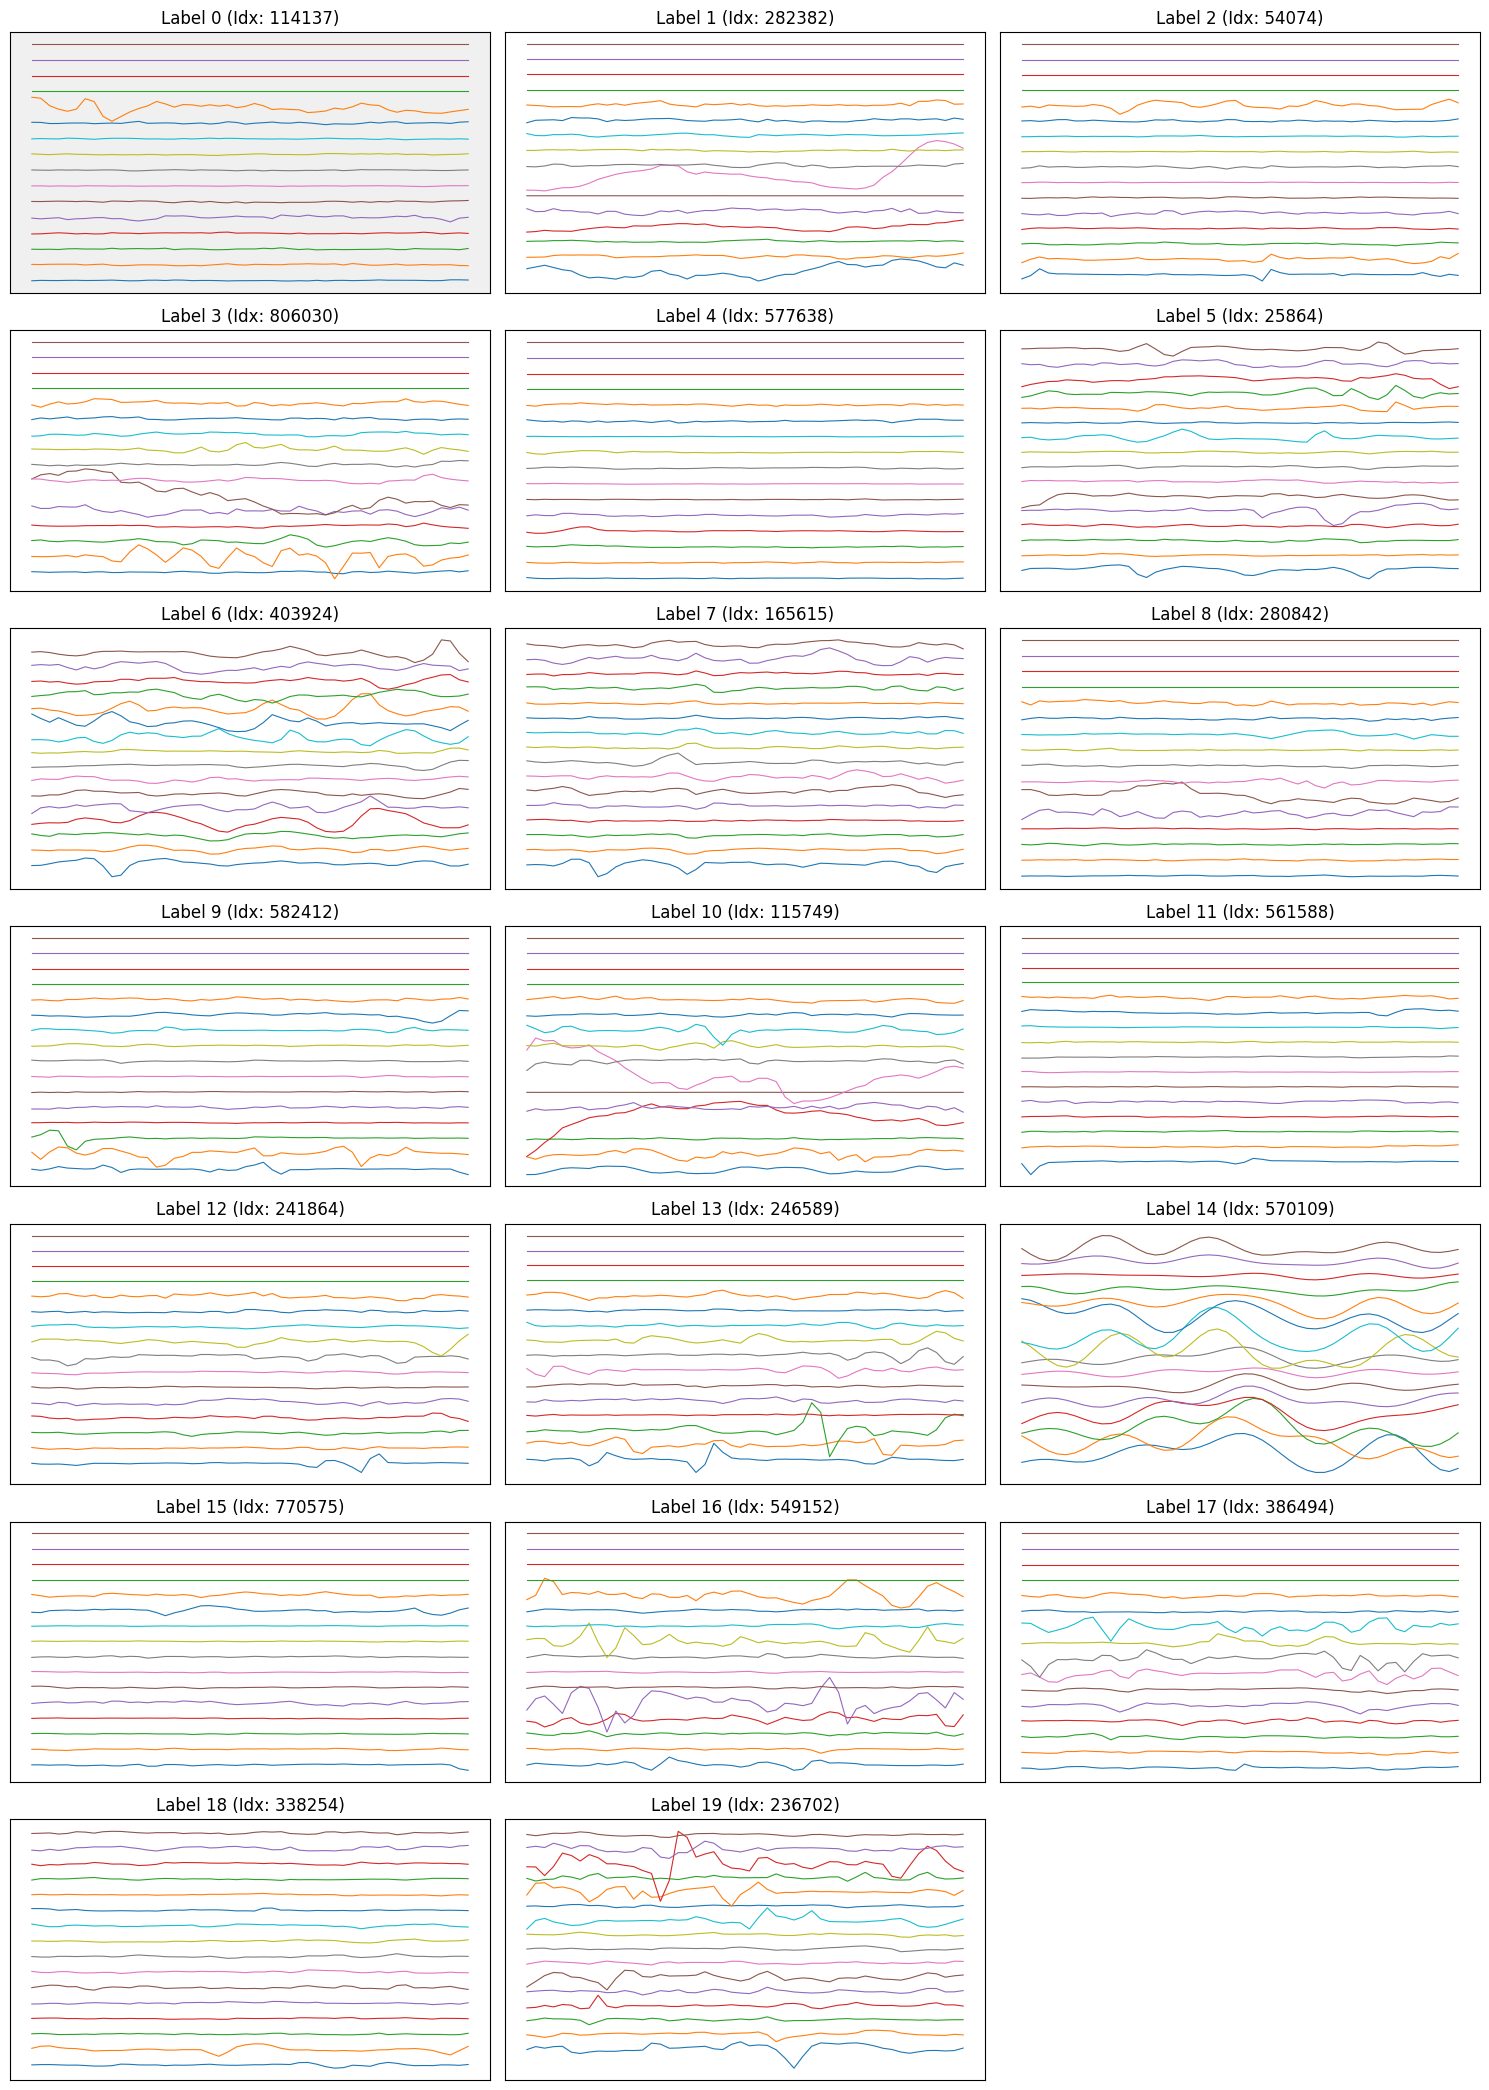

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import math

def check_all_labels(X, y):
    # 1. 라벨 변환 (One-hot -> Integer)
    if y.ndim > 1:
        y_int = np.argmax(y, axis=1)
    else:
        y_int = y
        
    unique_labels = np.sort(np.unique(y_int))
    num_classes = len(unique_labels)
    
    print(f"=== 🔎 전체 라벨({num_classes}개) 신호 상태 점검 ===")
    
    # -------------------------------------------------------
    # 1. 수치 리포트 (건강 검진)
    # -------------------------------------------------------
    print("\n[1] 라벨별 평균 진폭(Activity) 확인")
    print(f"{'Label':<6} | {'Status':<10} | {'Mean Peak-to-Peak':<20} | {'Sample Count':<10}")
    print("-" * 55)
    
    for label in unique_labels:
        # 해당 라벨의 모든 데이터 인덱스
        indices = np.where(y_int == label)[0]
        
        if len(indices) == 0:
            print(f"{label:<6} | ❌ EMPTY    | -                    | 0")
            continue
            
        # 해당 라벨 데이터 전체의 평균 진폭 계산 (샘플링하여 계산 속도 향상)
        # 100개만 뽑아서 통계 냄
        sample_indices = np.random.choice(indices, min(len(indices), 100), replace=False)
        samples = X[sample_indices]
        
        # (최대 - 최소)의 평균 계산
        p2p = np.mean(np.max(samples, axis=1) - np.min(samples, axis=1))
        
        status = "✅ OK" if p2p > 0.5 else ("⚠️ Weak" if p2p > 0.1 else "💀 Flat")
        if label == 0 and p2p < 1.0: status = "💤 Rest" # 휴식은 원래 약함
        
        print(f"{label:<6} | {status:<10} | {p2p:.4f}               | {len(indices)}")

    # -------------------------------------------------------
    # 2. 그리드 시각화 (눈으로 확인)
    # -------------------------------------------------------
    print("\n[2] 라벨별 파형 시각화 (랜덤 1개 샘플)")
    
    cols = 3
    rows = math.ceil(num_classes / cols)
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
    axes = axes.flatten() # 반복문 돌리기 쉽게 1차원으로 폅니다
    
    for i, label in enumerate(unique_labels):
        ax = axes[i]
        
        # 해당 라벨의 데이터 중 하나 랜덤 선택
        indices = np.where(y_int == label)[0]
        if len(indices) == 0:
            ax.text(0.5, 0.5, "No Data", ha='center', va='center')
            continue
            
        idx = np.random.choice(indices)
        data = X[idx] # (50, 16)
        
        # 16개 채널 겹쳐 그리기 (Offset 적용)
        offset = 0
        gap = 4 # 그래프 간격
        for ch in range(data.shape[1]):
            ax.plot(data[:, ch] + offset, linewidth=0.8)
            offset += gap
            
        ax.set_title(f"Label {label} (Idx: {idx})")
        ax.set_xticks([]) # X축 눈금 숨김 (깔끔하게)
        ax.set_yticks([]) # Y축 눈금 숨김
        ax.grid(True, alpha=0.2)
        
        # 배경색으로 상태 표시 (휴식=회색, 동작=흰색)
        if label == 0:
            ax.set_facecolor('#f0f0f0') 

    # 남은 빈 칸 끄기
    for i in range(num_classes, len(axes)):
        axes[i].axis('off')
        
    plt.tight_layout()
    plt.show()

# === 실행 ===
if 'X_train' in locals():
    check_all_labels(X_train, y_train)
else:
    print("X_train 데이터가 없습니다.")

In [13]:
import tensorflow as tf
import os

# 1. GPU(MPS) 인식 확인
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # GPU 메모리 증가 허용 (필수: 안 하면 메모리 부족 뜰 수 있음)
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✅ [성공] M4 GPU 가속 활성화됨: {gpus}")
    except RuntimeError as e:
        print(e)
else:
    print("❌ [실패] GPU를 찾을 수 없습니다. 'pip install tensorflow-metal'을 확인하세요.")

# 2. 확실하게 GPU 사용 강제 설정
tf.debugging.set_log_device_placement(False) # True로 하면 로그가 너무 많이 뜸

✅ [성공] M4 GPU 가속 활성화됨: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2026-01-09 12:50:50.447307: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2026-01-09 12:50:50.451593: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2026-01-09 12:50:50.451607: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 12.48 GB
2026-01-09 12:50:50.451756: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2026-01-09 12:50:50.451772: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 50, 64)         │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 50, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 25, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 25, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 25, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 25, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 12, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │         2,580 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 327,252 (1.25 MB)

 Trainable params: 326,868 (1.25 MB)

 Non-trainable params: 384 (1.50 KB)


🚀 [M4 GPU] 학습 시작...
Epoch 1/100


2026-01-09 12:51:10.023385: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


6459/6459 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.5777 - loss: 1.5386
Epoch 1: val_accuracy improved from None to 0.69633, saving model to best_cnn_lstm_model_m4.keras
6459/6459 ━━━━━━━━━━━━━━━━━━━━ 506s 78ms/step - accuracy: 0.6282 - loss: 1.3557 - val_accuracy: 0.6963 - val_loss: 1.0861 - learning_rate: 0.0010
Epoch 2/100
6459/6459 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.6794 - loss: 1.1751
Epoch 2: val_accuracy improved from 0.69633 to 0.71094, saving model to best_cnn_lstm_model_m4.keras
6459/6459 ━━━━━━━━━━━━━━━━━━━━ 503s 78ms/step - accuracy: 0.6838 - loss: 1.1600 - val_accuracy: 0.7109 - val_loss: 1.0453 - learning_rate: 0.0010
Epoch 3/100
6459/6459 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.6936 - loss: 1.1263
Epoch 3: val_accuracy improved from 0.71094 to 0.72294, saving model to best_cnn_lstm_model_m4.keras
6459/6459 ━━━━━━━━━━━━━━━━━━━━ 503s 78ms/step - accuracy: 0.6959 - loss: 1.1190 - val_accuracy: 0.7229 - val_loss: 0.9866 - learning_rate: 0.0010
Epoc

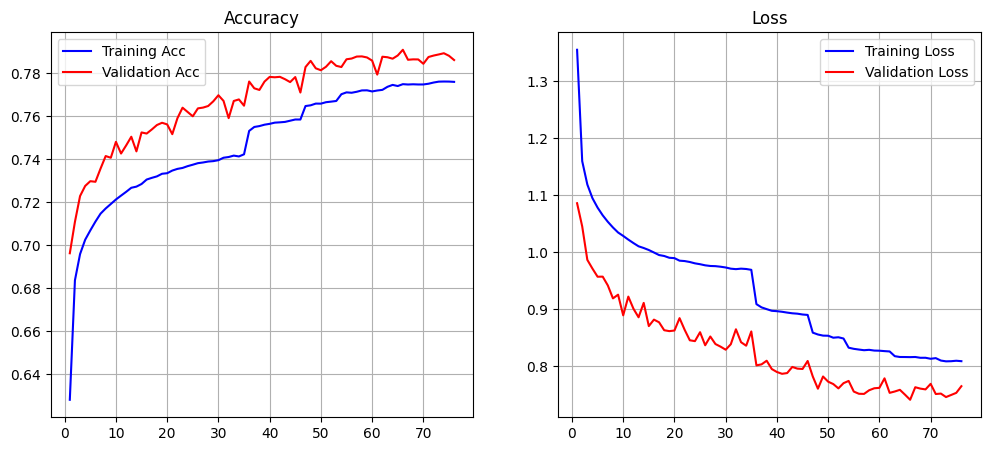


🏆 최종 테스트 정확도: 79.24%


In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# =========================================================
# GPU 스코프 내에서 실행 (Mac M4 가속)
# =========================================================
with tf.device('/device:GPU:0'):

    # 1. 모델 정의
    def build_cnn_lstm_model(input_shape, num_classes):
        model = Sequential()
        
        # [CNN Part]
        model.add(Input(shape=input_shape))
        
        # Block 1
        model.add(Conv1D(64, kernel_size=3, padding='same', activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=2))
        model.add(Dropout(0.3))

        # Block 2
        model.add(Conv1D(128, kernel_size=3, padding='same', activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=2)) 
        model.add(Dropout(0.3))

        # [LSTM Part] - Mac GPU 최적화
        # recurrent_dropout=0 (기본값)이어야 CuDNN/MPS 가속을 받습니다. 절대 건드리지 마세요.
        # unroll=False (기본값) 유지
        model.add(Bidirectional(LSTM(128, return_sequences=False))) 
        model.add(Dropout(0.4))

        # [Classifier Part]
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(num_classes, activation='softmax'))
        
        # 학습률 조정 (M1/M2/M3/M4에서는 Adam이 가장 안정적)
        optimizer = Adam(learning_rate=0.001)
        
        model.compile(loss='categorical_crossentropy', 
                      optimizer=optimizer, 
                      metrics=['accuracy'])
        return model

    # 2. 모델 생성
    input_shape = (X_train.shape[1], X_train.shape[2]) 
    num_classes = y_train.shape[1]
    
    model = build_cnn_lstm_model(input_shape, num_classes)
    model.summary()

    # 3. 콜백 설정
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
    checkpoint = ModelCheckpoint('best_cnn_lstm_model_m4.keras', monitor='val_accuracy', save_best_only=True, verbose=1)

    # 4. 학습 시작
    print("\n🚀 [M4 GPU] 학습 시작...")
    
    # Mac GPU 활용 팁: batch_size를 키우면 GPU 효율이 올라갑니다.
    # 메모리가 넉넉하다면 64 -> 128 or 256으로 늘려보세요. 속도가 훨씬 빨라집니다.
    BATCH_SIZE = 128  # M4 성능 믿고 128로 상향 (메모리 부족시 64로 내림)
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=BATCH_SIZE, 
        callbacks=[early_stopping, reduce_lr, checkpoint],
        verbose=1
    )

print("\n✅ 학습 완료!")

# ---------------------------------------------------------
# 5. 결과 시각화
# ---------------------------------------------------------
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Training Acc')
    plt.plot(epochs, val_acc, 'r-', label='Validation Acc')
    plt.title('Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_history(history)

# ---------------------------------------------------------
# 6. 최종 테스트 평가
# ---------------------------------------------------------
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\n🏆 최종 테스트 정확도: {test_acc*100:.2f}%")

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Dense, Dropout, BatchNormalization, Activation, Add, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# =========================================================
# GPU 스코프 내에서 실행 (Mac M4 가속)
# =========================================================
with tf.device('/device:GPU:0'):

    # -----------------------------------------------------
    # 1. TCN 핵심 블록 정의 (Residual Block)
    # -----------------------------------------------------
    def tcn_residual_block(x, filters, kernel_size, dilation_rate, dropout_rate=0.3):
        """
        TCN의 핵심인 잔차 블록(Residual Block)입니다.
        Dilated Conv -> Norm -> Relu -> Dropout 순서로 진행됩니다.
        """
        prev_x = x
        
        # [Layer 1]
        # padding='causal': 미래의 정보를 보지 않고 과거 정보만 사용 (시계열 특성 유지)
        x = Conv1D(filters=filters, 
                   kernel_size=kernel_size, 
                   dilation_rate=dilation_rate, 
                   padding='causal',
                   activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(dropout_rate)(x)

        # [Layer 2] 한번 더 반복
        x = Conv1D(filters=filters, 
                   kernel_size=kernel_size, 
                   dilation_rate=dilation_rate, 
                   padding='causal',
                   activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(dropout_rate)(x)

        # [Skip Connection] 입력과 출력의 차원을 맞춰서 더해줌
        if prev_x.shape[-1] != filters:
            prev_x = Conv1D(filters=filters, kernel_size=1, padding='same')(prev_x)
            
        # 입력값(Original) + 처리값(Processed) -> 정보 손실 방지
        res = Add()([prev_x, x])
        return Activation('relu')(res)

    # -----------------------------------------------------
    # 2. 전체 TCN 모델 조립
    # -----------------------------------------------------
    def build_tcn_model(input_shape, num_classes):
        inputs = Input(shape=input_shape)
        
        # 초기 특징 추출
        x = Conv1D(64, kernel_size=3, padding='causal', activation='relu')(inputs)
        
        # TCN 블록 쌓기 (Dilation을 1, 2, 4, 8... 로 늘려가며 넓은 범위를 봄)
        # filters: 필터 수 (모델 용량)
        x = tcn_residual_block(x, filters=64, kernel_size=3, dilation_rate=1)
        x = tcn_residual_block(x, filters=128, kernel_size=3, dilation_rate=2)
        x = tcn_residual_block(x, filters=128, kernel_size=3, dilation_rate=4)
        x = tcn_residual_block(x, filters=256, kernel_size=3, dilation_rate=8)
        
        # 최종 특징 압축 (Global Average Pooling이 LSTM의 마지막 output 역할 대체)
        x = GlobalAveragePooling1D()(x)
        
        # 분류기 (Classifier)
        x = Dense(128, activation='relu')(x)
        x = Dropout(0.4)(x)
        outputs = Dense(num_classes, activation='softmax')(x)
        
        model = Model(inputs=inputs, outputs=outputs, name="TCN_Model")
        
        optimizer = Adam(learning_rate=0.001)
        model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        
        return model

    # -----------------------------------------------------
    # 3. 모델 생성 및 확인
    # -----------------------------------------------------
    input_shape = (X_train.shape[1], X_train.shape[2]) # (50, 16)
    num_classes = y_train.shape[1]                     # 18
    
    model_tcn = build_tcn_model(input_shape, num_classes)
    model_tcn.summary()

    # -----------------------------------------------------
    # 4. 학습 시작
    # -----------------------------------------------------
    # 콜백 설정
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
    checkpoint = ModelCheckpoint('best_tcn_model_m4.keras', monitor='val_accuracy', save_best_only=True, verbose=1)

    print("\n🚀 [M4 GPU] TCN 모델 학습 시작...")
    
    # TCN은 가벼워서 배치 사이즈를 더 키워도 됩니다 (128 ~ 256 권장)
    history_tcn = model_tcn.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=128,
        callbacks=[early_stopping, reduce_lr, checkpoint],
        verbose=1
    )

print("\n✅ TCN 학습 완료!")

Model: "TCN_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 50, 16)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 50, 64)    │      3,136 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 50, 64)    │     12,352 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 64)    │        256 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 50, 64)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 50, 64)    │     12,352 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 64)    │        256 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 50, 64)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 50, 64)    │          0 │ conv1d_2[0][0],   │
│                     │                   │            │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 50, 64)    │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 50, 128)   │     24,704 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 128)   │        512 │ conv1d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 50, 128)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 50, 128)   │     49,280 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 128)   │        512 │ conv1d_6[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 50, 128)   │      8,320 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 50, 128)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 50, 128)   │          0 │ conv1d_7[0][0],   │
│                     │                   │            │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 50, 128)   │          0 │ add_1[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 50, 128)   │     49,280 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 577,236 (2.20 MB)

 Trainable params: 574,932 (2.19 MB)

 Non-trainable params: 2,304 (9.00 KB)


🚀 [M4 GPU] TCN 모델 학습 시작...
Epoch 1/100
6459/6459 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.5498 - loss: 1.7441
Epoch 1: val_accuracy improved from None to 0.68080, saving model to best_tcn_model_m4.keras
6459/6459 ━━━━━━━━━━━━━━━━━━━━ 774s 119ms/step - accuracy: 0.6115 - loss: 1.4320 - val_accuracy: 0.6808 - val_loss: 1.1584 - learning_rate: 0.0010
Epoch 2/100
6459/6459 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.6793 - loss: 1.1708
Epoch 2: val_accuracy improved from 0.68080 to 0.70932, saving model to best_tcn_model_m4.keras
6459/6459 ━━━━━━━━━━━━━━━━━━━━ 802s 124ms/step - accuracy: 0.6855 - loss: 1.1530 - val_accuracy: 0.7093 - val_loss: 1.0607 - learning_rate: 0.0010
Epoch 3/100
6459/6459 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.6994 - loss: 1.1088
Epoch 3: val_accuracy improved from 0.70932 to 0.72463, saving model to best_tcn_model_m4.keras
6459/6459 ━━━━━━━━━━━━━━━━━━━━ 836s 129ms/step - accuracy: 0.7028 - loss: 1.0989 - val_accuracy: 0.7246 - val_loss: 1.00

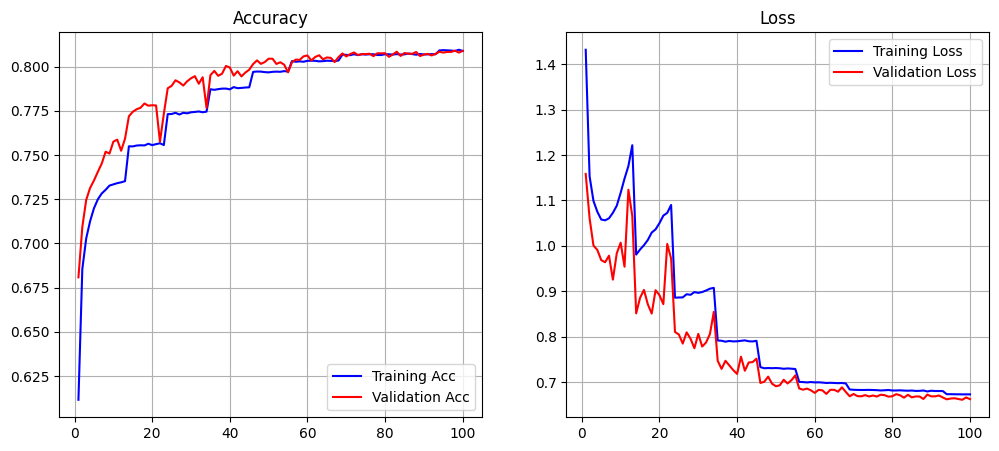


🏆 최종 테스트 정확도: 81.01%


In [16]:

# ---------------------------------------------------------
# 5. 결과 시각화
# ---------------------------------------------------------
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Training Acc')
    plt.plot(epochs, val_acc, 'r-', label='Validation Acc')
    plt.title('Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_history(history_tcn)

# ---------------------------------------------------------
# 6. 최종 테스트 평가
# ---------------------------------------------------------
test_loss, test_acc = model_tcn.evaluate(X_test, y_test, verbose=0)
print(f"\n🏆 최종 테스트 정확도: {test_acc*100:.2f}%")